In [ ]:
import requests
import pandas as pd
import time
from datetime import datetime, timedelta

In [ ]:
# API 설정
API_KEY = 'a9dcbb71-880f-48b5-9d79-a7ca21fd491f'
BASE_URL = 'https://content.guardianapis.com/search'

# ESG 키워드 (BBC와 동일)
env_keywords = [
    'ESG', 'environment', 'sustainability', 'sustainable', 'climate', 'carbon',
    'net zero', 'global warming', 'renewable', 'green energy', 'green technology',
    'biodiversity', 'pollution', 'clean energy', 'solar', 'wind power', 'recycling',
    'decarbonisation', 'energy transition', 'climate change', 'zero emissions',
    'environmental policy', 'fossil fuel', 'deforestation', 'water scarcity',
    'plastic waste', 'circular economy', 'emission', 'greenhouse gas',
    'paris agreement', 'electric vehicle', 'EV', 'COP28', 'COP29'
]

social_keywords = [
    'social', 'human rights', 'diversity', 'inclusion', 'equity', 'equality',
    'employee', 'worker', 'labor', 'labour', 'workforce', 'employment',
    'welfare', 'health', 'safety', 'mental health', 'wellbeing',
    'wage', 'living wage', 'poverty', 'inequality', 'discrimination',
    'gender equality', 'women', 'minority', 'indigenous', 'disability',
    'child labour', 'modern slavery', 'refugee', 'immigrant',
    'education', 'training', 'community', 'charity', 'humanitarian'
]

gov_keywords = [
    'governance', 'corporate governance', 'board', 'director', 'CEO', 'executive',
    'shareholder', 'investor', 'ownership', 'management',
    'transparency', 'accountability', 'disclosure', 'reporting',
    'compliance', 'regulation', 'regulatory', 'ethics', 'ethical',
    'scandal', 'fraud', 'corruption', 'bribery', 'investigation', 'lawsuit',
    'tax', 'tax avoidance', 'audit', 'vote', 'AGM',
    'executive compensation', 'bonus', 'whistleblower', 'greenwashing'
]

In [ ]:
def search_guardian(query, from_date, to_date, page=1, page_size=200):
    """Guardian API 검색"""
    params = {
        'api-key': API_KEY,
        'q': query,
        'from-date': from_date,
        'to-date': to_date,
        'page': page,
        'page-size': page_size,
        'show-fields': 'headline,byline,bodyText,trailText,wordcount',
        'order-by': 'relevance'  # 관련도순 수집
    }

    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

def collect_period(query, from_date, to_date, max_articles):
    """특정 기간의 기사 수집"""
    articles = []
    page = 1

    while len(articles) < max_articles:
        data = search_guardian(query, from_date, to_date, page=page)

        if not data or data['response']['status'] != 'ok':
            break

        results = data['response']['results']
        total_pages = data['response']['pages']

        if not results:
            break

        for article in results:
            if len(articles) >= max_articles:
                break

            articles.append({
                'id': article.get('id'),
                'type': article.get('type'),
                'section': article.get('sectionName'),
                'date': article.get('webPublicationDate'),
                'title': article.get('webTitle'),
                'url': article.get('webUrl'),
                'headline': article.get('fields', {}).get('headline'),
                'byline': article.get('fields', {}).get('byline'),
                'body': article.get('fields', {}).get('bodyText'),
                'trail_text': article.get('fields', {}).get('trailText'),
                'wordcount': article.get('fields', {}).get('wordcount')
            })

        print(f"  페이지 {page}/{total_pages} | 수집: {len(articles)}개", end='\r')

        if page >= total_pages or len(articles) >= max_articles:
            break

        page += 1
        time.sleep(1)  # API 제한 준수

    print()  # 줄바꿈
    return articles

def collect_by_quarters():
    """분기별로 나눠서 수집 (골고루 분포)"""

    # 분기별 기간 정의 (총 8분기)
    periods = [
        ('2023-01-01', '2023-03-31', '2023 Q1'),
        ('2023-04-01', '2023-06-30', '2023 Q2'),
        ('2023-07-01', '2023-09-30', '2023 Q3'),
        ('2023-10-01', '2023-12-31', '2023 Q4'),
        ('2024-01-01', '2024-03-31', '2024 Q1'),
        ('2024-04-01', '2024-06-30', '2024 Q2'),
        ('2024-07-01', '2024-09-30', '2024 Q3'),
        ('2024-10-01', '2024-12-31', '2024 Q4'),
    ]

    # 분기당 목표
    articles_per_period = 6250

    # 키워드 그룹 (간단하게)
    all_keywords = env_keywords + social_keywords + gov_keywords
    query = ' OR '.join(all_keywords[:30])  # 상위 30개 키워드만

    all_articles = []

    for from_date, to_date, label in periods:
        print(f"\n{'='*60}")
        print(f"수집 중: {label} ({from_date} ~ {to_date})")
        print(f"{'='*60}")

        articles = collect_period(query, from_date, to_date, articles_per_period)
        all_articles.extend(articles)

        print(f"✅ {label} 완료: {len(articles)}개 수집 | 총: {len(all_articles)}개")

        # 중간 저장
        if len(all_articles) > 0:
            temp_df = pd.DataFrame(all_articles)
            temp_df.to_csv('guardian_temp.csv', index=False, encoding='utf-8-sig')

    return pd.DataFrame(all_articles)

In [ ]:
if __name__ == "__main__":
    print("Guardian API ESG 뉴스 수집 시작 (분기별)")
    print(f"기간: 2023-01-01 ~ 2024-12-31 (8분기)")
    print(f"목표: 약 50,000개 (분기당 6,250개)")
    print(f"호주 뉴스는 자동으로 제외됩니다.\n")

    # 데이터 수집
    df = collect_by_quarters()

    # 중복 제거
    print(f"\n{'='*60}")
    print("데이터 정리")
    print(f"{'='*60}")

    df_unique = df.drop_duplicates(subset=['id']).copy()
    print(f"중복 제거 전: {len(df)}개")
    print(f"중복 제거 후: {len(df_unique)}개")

    # 호주 뉴스 제외
    df_unique = df_unique[df_unique['section'] != 'Australia news'].copy()
    print(f"호주 뉴스 제외 후: {len(df_unique)}개")

    # 날짜 변환
    df_unique['date'] = pd.to_datetime(df_unique['date'])

    # 저장
    df_unique.to_csv('guardian_esg_2023_2024_balanced.csv', index=False, encoding='utf-8-sig')
    print(f"\n✅ 저장 완료: English_2023_2024.csv")

    # 통계
    print(f"\n{'='*60}")
    print("수집 통계")
    print(f"{'='*60}")
    print(f"총 기사 수: {len(df_unique)}")

    print(f"\n섹션별 분포 (상위 10개):")
    print(df_unique['section'].value_counts().head(10))

    print(f"\n월별 분포:")
    monthly = df_unique['date'].dt.to_period('M').value_counts().sort_index()
    print(monthly)

    print(f"\n연도별 분포:")
    yearly = df_unique['date'].dt.year.value_counts().sort_index()
    print(yearly)

Guardian API ESG 뉴스 수집 시작 (분기별)
기간: 2023-01-01 ~ 2024-12-31 (8분기)
목표: 약 50,000개 (분기당 6,250개)
호주 뉴스는 자동으로 제외됩니다.


수집 중: 2023 Q1 (2023-01-01 ~ 2023-03-31)
  페이지 30/30 | 수집: 5938개
✅ 2023 Q1 완료: 5938개 수집 | 총: 5938개

수집 중: 2023 Q2 (2023-04-01 ~ 2023-06-30)
  페이지 26/26 | 수집: 5123개
✅ 2023 Q2 완료: 5123개 수집 | 총: 11061개

수집 중: 2023 Q3 (2023-07-01 ~ 2023-09-30)
  페이지 30/30 | 수집: 5877개
✅ 2023 Q3 완료: 5877개 수집 | 총: 16938개

수집 중: 2023 Q4 (2023-10-01 ~ 2023-12-31)
  페이지 29/29 | 수집: 5665개
✅ 2023 Q4 완료: 5665개 수집 | 총: 22603개

수집 중: 2024 Q1 (2024-01-01 ~ 2024-03-31)
  페이지 27/27 | 수집: 5256개
✅ 2024 Q1 완료: 5256개 수집 | 총: 27859개

수집 중: 2024 Q2 (2024-04-01 ~ 2024-06-30)
  페이지 30/30 | 수집: 5814개
✅ 2024 Q2 완료: 5814개 수집 | 총: 33673개

수집 중: 2024 Q3 (2024-07-01 ~ 2024-09-30)
  페이지 32/32 | 수집: 6202개
✅ 2024 Q3 완료: 6202개 수집 | 총: 39875개

수집 중: 2024 Q4 (2024-10-01 ~ 2024-12-31)
  페이지 27/27 | 수집: 5264개
✅ 2024 Q4 완료: 5264개 수집 | 총: 45139개

데이터 정리
중복 제거 전: 45139개
중복 제거 후: 45046개
호주 뉴스 제외 후: 39373개

✅ 저장 완료: English_2023_2024.c

/tmp/ipython-input-2809351301.py:40: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly = df_unique['date'].dt.to_period('M').value_counts().sort_index()


In [ ]:
#파일 로드
df = pd.read_csv('guardian_esg_2023_2024_balanced.csv', encoding='utf-8-sig')

print(f"✅ Loaded {len(df)} articles")

✅ Loaded 39373 articles


In [ ]:
# 1. 기본 정보
print(f"\n📌 Total articles: {len(df):,}")
print(f"📌 Columns: {df.columns.tolist()}")
print(f"📌 Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. 결측치 확인
print(f"\n📌 Missing values:")
print(df.isnull().sum())

# 3. 샘플 데이터 확인
print(f"\n📌 Sample data:")
print(df.head(3))

# 4. 각 컬럼 데이터 타입
print(f"\n📌 Data types:")
print(df.dtypes)


📌 Total articles: 39,373
📌 Columns: ['id', 'type', 'section', 'date', 'title', 'url', 'headline', 'byline', 'body', 'trail_text', 'wordcount']
📌 Memory usage: 591.62 MB

📌 Missing values:
id               0
type             0
section          0
date             0
title            0
url              0
headline         0
byline        1052
body            71
trail_text       0
wordcount        0
dtype: int64

📌 Sample data:
                                                  id     type      section  \
0  environment/2023/mar/21/methane-to-food-waste-...  article  Environment   
1  environment/2023/mar/07/hydrogen-clean-fuel-cl...  article  Environment   
2  commentisfree/2023/mar/30/the-guardian-view-on...  article      Opinion   

                        date  \
0  2023-03-21 19:10:39+00:00   
1  2023-03-07 08:30:31+00:00   
2  2023-03-30 17:30:03+00:00   

                                               title  \
0  Eight things the world must do to avoid the wo...   
1  Is hydrogen real

In [ ]:
# 1. 불필요한 컬럼 제거
df = df.drop(columns=['byline'])

In [ ]:
# 3. 결측치 처리
print("🔍 Handling missing values...")

# 먼저 확인
title_missing = df['title'].isnull().sum()
body_missing = df['body'].isnull().sum()
trail_text_missing = df['trail_text'].isnull().sum()

print(f"📌 제목 결측: {title_missing}개")
print(f"📌 본문 결측: {body_missing}개")
print(f"📌 요약 결측: {trail_text_missing}개")

# 결측치가 있을 때만 제거
if title_missing > 0 or body_missing > 0 or trail_text_missing > 0:
    original_count = len(df)
    df = df.dropna(subset=['title', 'body', 'trail_text']).copy()
    removed = original_count - len(df)
    print(f"✅ {removed}개 기사 제거 완료")
else:
    print("✅ 결측치 없음 - 제거 불필요")

print(f"📌 최종 기사 수: {len(df):,}")

🔍 Handling missing values...
📌 제목 결측: 0개
📌 본문 결측: 71개
📌 요약 결측: 0개
✅ 71개 기사 제거 완료
📌 최종 기사 수: 39,302


In [ ]:
sample = str(df['date'].iloc[0])
print(f"\n현재 형식 분석:")
if '/' in sample:
    print("  → 슬래시(/) 포함 - 이미 영국식일 가능성")
elif 'T' in sample or '+' in sample:
    print("  → ISO 형식 (YYYY-MM-DDTHH:MM:SS) - 변환 필요")
elif '-' in sample and sample.count('-') == 2:
    print("  → 하이픈(-) 형식 (YYYY-MM-DD) - 변환 필요")
else:
    print(f"  → 알 수 없는 형식: {sample}")


현재 형식 분석:
  → ISO 형식 (YYYY-MM-DDTHH:MM:SS) - 변환 필요


In [ ]:
# Datetime 변환
df['date'] = pd.to_datetime(df['date'])

# 영국식 표시 (DD/MM/YYYY)
df['date_uk'] = df['date'].dt.strftime('%d/%m/%Y')

# 분석용 컬럼
df['year_month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

#날짜 변환 확인
print(f"✅ 날짜 범위: {df['date_uk'].min()} ~ {df['date_uk'].max()}")
print(f"   총 기간: {df['year'].min()}년 ~ {df['year'].max()}년")
print(f"   예시: {df['date_uk'].iloc[0]}")

# 변환 후 컬럼 확인
print("\n새로 추가된 컬럼:")
print(df[['date', 'date_uk', 'year_month', 'year', 'month']].head())

✅ 날짜 범위: 01/01/2023 ~ 31/12/2024
   총 기간: 2023년 ~ 2024년
   예시: 21/03/2023

새로 추가된 컬럼:
                       date     date_uk year_month  year  month
0 2023-03-21 19:10:39+00:00  21/03/2023    2023-03  2023      3
1 2023-03-07 08:30:31+00:00  07/03/2023    2023-03  2023      3
2 2023-03-30 17:30:03+00:00  30/03/2023    2023-03  2023      3
3 2023-03-28 15:00:03+00:00  28/03/2023    2023-03  2023      3
4 2023-03-15 18:11:38+00:00  15/03/2023    2023-03  2023      3


/tmp/ipython-input-884410040.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['year_month'] = df['date'].dt.to_period('M')


In [ ]:
print("\n📌 Step 4: 본문 길이 분석")

df['body_length'] = df['body'].str.len()

print(f"✅ 본문 길이 통계:")
print(f"   평균: {df['body_length'].mean():.0f}자")
print(f"   중간값: {df['body_length'].median():.0f}자")
print(f"   최소: {df['body_length'].min()}자")
print(f"   최대: {df['body_length'].max()}자")


📌 Step 4: 본문 길이 분석
✅ 본문 길이 통계:
   평균: 7190자
   중간값: 4842자
   최소: 2자
   최대: 210120자


In [ ]:
# 영국: 400자 이상 (2배)
df_filtered = df[
    (df['body'].str.len() >= 400) &
    (df['body'].str.len() <= 10000)
]

print(f"필터링 전: {len(df)}개")
print(f"필터링 후: {len(df_filtered)}개")
print(f"제거된 기사: {len(df) - len(df_filtered)}개 ({(len(df) - len(df_filtered)) / len(df) * 100:.1f}%)")

필터링 전: 39302개
필터링 후: 34404개
제거된 기사: 4898개 (12.5%)


In [ ]:
# type별 분포 확인
print("type 분포:")
print(df['type'].value_counts())
print()

# article 아닌 것 확인
non_article = df[df['type'] != 'article']
print(f"article 아닌 것: {len(non_article)}개")
if len(non_article) > 0:
    print("\n샘플:")
    print(non_article[['type', 'title', 'section']].head())

# article만 유지
df_article = df[df['type'] == 'article'].copy()

print(f"\n필터링 후: {len(df_article)}개")
print(f"제거된 항목: {len(df) - len(df_article)}개")

# 섹션별 분포 재확인
print(f"\n섹션별 분포 (상위 10개):")
print(df_article['section'].value_counts().head(10))

# df 업데이트
df = df_article

type 분포:
type
article        36985
liveblog        2198
interactive      108
audio             11
Name: count, dtype: int64

article 아닌 것: 2317개

샘플:
         type                                              title   section
117  liveblog  Davos day three: Keir Starmer says Rishi Sunak...  Business
204  liveblog  Spanish inflation almost halves and German CPI...  Business
209  liveblog  Rishi Sunak grilled on small boats, childcare ...  Politics
229  liveblog  Davos day 1: China ‘passed peak Covid’; Kissin...  Business
239  liveblog  Davos day 2: Germany’s Scholz not drawn on Ukr...  Business

필터링 후: 36985개
제거된 항목: 2317개

섹션별 분포 (상위 10개):
section
Environment       4383
World news        4325
Opinion           3229
Business          2912
US news           2761
Sport             2122
Football          1796
Politics          1731
Life and style    1463
UK news           1383
Name: count, dtype: int64


In [ ]:
# 제목 + 본문 + 요약문 통합
df['analysis_text'] = (
    df['title'].fillna('') + ' ' +
    df['body'].fillna('') + ' ' +
    df['trail_text'].fillna('')
)

# 길이 계산
df['analysis_text_length'] = df['analysis_text'].str.len()

print("=" * 60)
print("통합 텍스트 생성")
print("=" * 60)
print(f"\n✅ 통합 텍스트 생성 완료")
print(f"📌 평균 길이: {df['analysis_text_length'].mean():.0f}자")
print(f"📌 중간값: {df['analysis_text_length'].median():.0f}자")
print(f"📌 최소: {df['analysis_text_length'].min()}자")
print(f"📌 최대: {df['analysis_text_length'].max()}자")

통합 텍스트 생성

✅ 통합 텍스트 생성 완료
📌 평균 길이: 5597자
📌 중간값: 4889자
📌 최소: 257자
📌 최대: 53265자


In [ ]:
# 10,000자 이상 기사 샘플 확인
very_long = df[df['analysis_text_length'] > 10000]

print("10,000자 이상 기사 (613개):")
print("\n섹션별 분포:")
print(very_long['section'].value_counts().head(10))

print("\n샘플 5개:")
for i in range(5):
    print(f"\n[{i+1}] {very_long['section'].iloc[i]}")
    print(f"    제목: {very_long['title'].iloc[i][:80]}...")
    print(f"    길이: {very_long['analysis_text_length'].iloc[i]:,}자")
    print(f"    단어수: {very_long['wordcount'].iloc[i]:,}개")

10,000자 이상 기사 (613개):

섹션별 분포:
section
World news        670
US news           320
Life and style    244
Environment       219
Society            94
Film               88
Sport              88
Music              82
Football           81
Politics           79
Name: count, dtype: int64

샘플 5개:

[1] Environment
    제목: ‘No miracles needed’: Prof Mark Jacobson on how wind, sun and water can power th...
    길이: 10,589자
    단어수: 1,733개

[2] Environment
    제목: Revealed: 1,000 super-emitting methane leaks risk triggering climate tipping poi...
    길이: 16,421자
    단어수: 2,644개

[3] US news
    제목: The man in charge of how the US spends $400bn to shift away from fossil fuels...
    길이: 10,830자
    단어수: 1,759개

[4] Environment
    제목: Brown gold: the great American manure rush begins...
    길이: 10,843자
    단어수: 1,676개

[5] Environment
    제목: Safeguard mechanism: what is it, will it cut emissions and what role do carbon o...
    길이: 12,630자
    단어수: 2,046개



⏳ Step 1: 샘플 500개로 유사도 분포 확인...
⏳ 유사도 계산 중...

✅ 유사도 분석 완료!


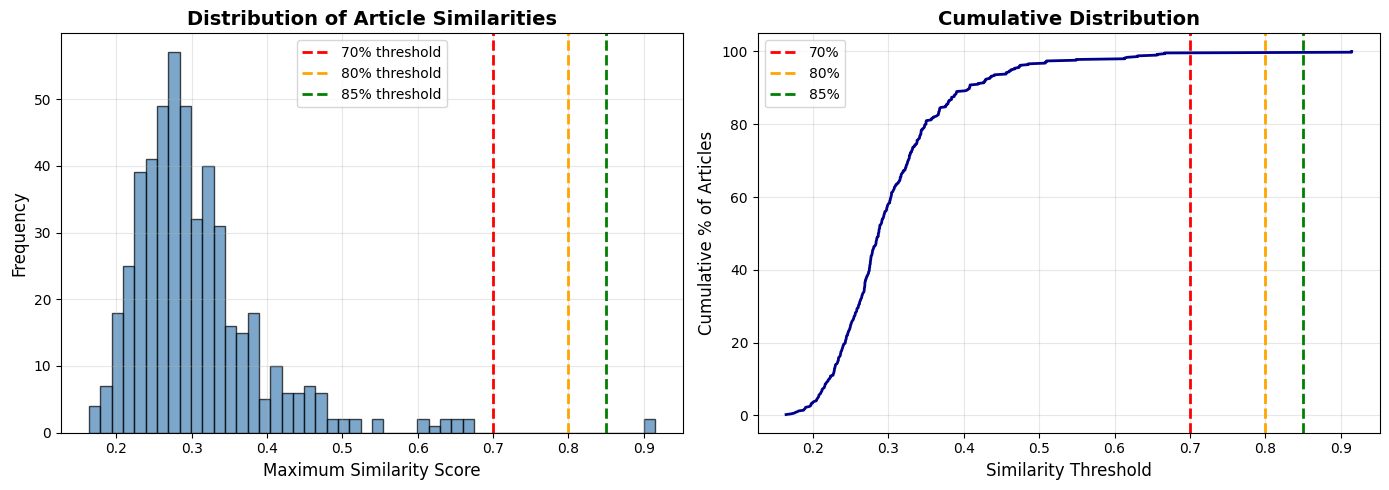


유사도 통계 (샘플 500개)
평균 최대 유사도: 0.306
중간값:          0.287
75 percentile:   0.338
90 percentile:   0.407
95 percentile:   0.463

Threshold별 중복 예상 개수
70% 이상:   2개 (  0.4%) → 전체 예상: ~147개
75% 이상:   2개 (  0.4%) → 전체 예상: ~147개
80% 이상:   2개 (  0.4%) → 전체 예상: ~147개
85% 이상:   2개 (  0.4%) → 전체 예상: ~147개
90% 이상:   2개 (  0.4%) → 전체 예상: ~147개

고유사도 기사 샘플 (유사도 > 0.8)

[유사도: 0.915]
기사 1: Olympic Games: Australians in action on day six in Paris...
기사 2: Olympic Games: Australians in action on day two in Paris...

[유사도: 0.915]
기사 1: Olympic Games: Australians in action on day two in Paris...
기사 2: Olympic Games: Australians in action on day six in Paris...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# 1. 샘플로 먼저 테스트 (전체는 시간 오래 걸림)
print("\n⏳ Step 1: 샘플 500개로 유사도 분포 확인...")

sample_size = 500
df_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

# TF-IDF 벡터화 (제목 + 키워드 사용)
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),  # 단어 + 2-gram
    min_df=2  # 최소 2번 이상 등장
)

# 제목 + 요약으로 벡터화
sample_texts = (df_sample['title'].fillna('') + ' ' +
                df_sample['trail_text'].fillna('')).values

tfidf_matrix = vectorizer.fit_transform(sample_texts)

# 코사인 유사도 계산
print("⏳ 유사도 계산 중...")
similarity_matrix = cosine_similarity(tfidf_matrix)

# 자기 자신 제외 (대각선 = 1.0 제거)
np.fill_diagonal(similarity_matrix, 0)

# 각 기사의 최대 유사도 찾기
max_similarities = similarity_matrix.max(axis=1)

# 분포 시각화
print("\n✅ 유사도 분석 완료!")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 히스토그램
axes[0].hist(max_similarities, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='70% threshold')
axes[0].axvline(x=0.8, color='orange', linestyle='--', linewidth=2, label='80% threshold')
axes[0].axvline(x=0.85, color='green', linestyle='--', linewidth=2, label='85% threshold')
axes[0].set_xlabel('Maximum Similarity Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Article Similarities', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 누적 분포
sorted_sims = np.sort(max_similarities)
cumulative = np.arange(1, len(sorted_sims) + 1) / len(sorted_sims) * 100
axes[1].plot(sorted_sims, cumulative, linewidth=2, color='darkblue')
axes[1].axvline(x=0.7, color='red', linestyle='--', linewidth=2, label='70%')
axes[1].axvline(x=0.8, color='orange', linestyle='--', linewidth=2, label='80%')
axes[1].axvline(x=0.85, color='green', linestyle='--', linewidth=2, label='85%')
axes[1].set_xlabel('Similarity Threshold', fontsize=12)
axes[1].set_ylabel('Cumulative % of Articles', fontsize=12)
axes[1].set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 통계 출력
print(f"\n{'='*60}")
print(f"유사도 통계 (샘플 {sample_size}개)")
print(f"{'='*60}")
print(f"평균 최대 유사도: {max_similarities.mean():.3f}")
print(f"중간값:          {np.median(max_similarities):.3f}")
print(f"75 percentile:   {np.percentile(max_similarities, 75):.3f}")
print(f"90 percentile:   {np.percentile(max_similarities, 90):.3f}")
print(f"95 percentile:   {np.percentile(max_similarities, 95):.3f}")

print(f"\n{'='*60}")
print("Threshold별 중복 예상 개수")
print(f"{'='*60}")
for threshold in [0.70, 0.75, 0.80, 0.85, 0.90]:
    duplicates = (max_similarities >= threshold).sum()
    pct = duplicates / len(max_similarities) * 100
    estimated_total = int(duplicates / sample_size * len(df))
    print(f"{threshold:.0%} 이상: {duplicates:3d}개 ({pct:5.1f}%) → 전체 예상: ~{estimated_total:,}개")

# 고유사도 샘플 확인
print(f"\n{'='*60}")
print("고유사도 기사 샘플 (유사도 > 0.8)")
print(f"{'='*60}")

high_sim_indices = np.where(max_similarities > 0.8)[0]
if len(high_sim_indices) > 0:
    for idx in high_sim_indices[:3]:  # 상위 3개만
        article_idx = df_sample.index[idx]
        sim_score = max_similarities[idx]

        # 가장 유사한 기사 찾기
        most_similar_idx = similarity_matrix[idx].argmax()
        similar_article_idx = df_sample.index[most_similar_idx]

        print(f"\n[유사도: {sim_score:.3f}]")
        print(f"기사 1: {df.loc[article_idx, 'title'][:80]}...")
        print(f"기사 2: {df.loc[similar_article_idx, 'title'][:80]}...")
else:
    print("0.8 이상 고유사도 기사 없음")

In [ ]:
# 전체 데이터 벡터화
print("⏳ 전체 데이터 벡터화 중...")
all_texts = (df['title'].fillna('') + ' ' + df['trail_text'].fillna('')).values

vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = vectorizer.fit_transform(all_texts)

print(f"✅ 벡터화 완료: {tfidf_matrix.shape}")

# 배치로 유사도 계산
print("\n⏳ 배치 단위로 중복 찾는 중...")

duplicates_to_remove = set()
batch_size = 1000  # 한 번에 1000개씩

for i in range(0, len(df), batch_size):
    end_i = min(i + batch_size, len(df))

    # 현재 배치와 전체 간의 유사도 계산
    batch_similarity = cosine_similarity(tfidf_matrix[i:end_i], tfidf_matrix)

    # 자기 자신 제외
    for j in range(batch_similarity.shape[0]):
        batch_similarity[j, i+j] = 0

    # 0.8 이상 찾기
    for j in range(batch_similarity.shape[0]):
        similar_indices = np.where(batch_similarity[j] >= 0.8)[0]

        for k in similar_indices:
            if k > i + j:  # 나중 인덱스만 제거
                duplicates_to_remove.add(k)

    print(f"  진행: {end_i:,}/{len(df):,} ({end_i/len(df)*100:.1f}%) | 중복 발견: {len(duplicates_to_remove):,}개")

print(f"\n✅ 중복 탐지 완료")
print(f"제거할 기사: {len(duplicates_to_remove):,}개")

# 제거
df_dedup = df.drop(df.index[list(duplicates_to_remove)]).copy()

print(f"\n{'='*60}")
print("중복 제거 결과")
print(f"{'='*60}")
print(f"제거 전: {len(df):,}개")
print(f"제거 후: {len(df_dedup):,}개")
print(f"제거됨:   {len(duplicates_to_remove):,}개 ({len(duplicates_to_remove)/len(df)*100:.1f}%)")

df = df_dedup
print("\n✅ 중복 제거 완료!")

⏳ 전체 데이터 벡터화 중...
✅ 벡터화 완료: (36985, 1000)

⏳ 배치 단위로 중복 찾는 중...
  진행: 1,000/36,985 (2.7%) | 중복 발견: 14개
  진행: 2,000/36,985 (5.4%) | 중복 발견: 80개
  진행: 3,000/36,985 (8.1%) | 중복 발견: 148개
  진행: 4,000/36,985 (10.8%) | 중복 발견: 174개
  진행: 5,000/36,985 (13.5%) | 중복 발견: 188개
  진행: 6,000/36,985 (16.2%) | 중복 발견: 208개
  진행: 7,000/36,985 (18.9%) | 중복 발견: 264개
  진행: 8,000/36,985 (21.6%) | 중복 발견: 268개
  진행: 9,000/36,985 (24.3%) | 중복 발견: 280개
  진행: 10,000/36,985 (27.0%) | 중복 발견: 293개
  진행: 11,000/36,985 (29.7%) | 중복 발견: 299개
  진행: 12,000/36,985 (32.4%) | 중복 발견: 310개
  진행: 13,000/36,985 (35.1%) | 중복 발견: 314개
  진행: 14,000/36,985 (37.9%) | 중복 발견: 318개
  진행: 15,000/36,985 (40.6%) | 중복 발견: 321개
  진행: 16,000/36,985 (43.3%) | 중복 발견: 327개
  진행: 17,000/36,985 (46.0%) | 중복 발견: 335개
  진행: 18,000/36,985 (48.7%) | 중복 발견: 338개
  진행: 19,000/36,985 (51.4%) | 중복 발견: 339개
  진행: 20,000/36,985 (54.1%) | 중복 발견: 342개
  진행: 21,000/36,985 (56.8%) | 중복 발견: 346개
  진행: 22,000/36,985 (59.5%) | 중복 발견: 350개
  진행: 23,000/36,985 (62.2%)

### ESG 키워드 분석 & 분류

In [ ]:
# 기존 키워드 변수를 사전으로 변환
esg_keywords = {
    'E': env_keywords,
    'S': social_keywords,
    'G': gov_keywords
}

# ESG 점수 계산 함수
def calculate_esg_scores(text):
    """ESG 점수 계산"""
    if pd.isna(text):
        return {
            'e_score': 0, 's_score': 0, 'g_score': 0,
            'total_score': 0, 'dominant_category': 'Unknown'
        }

    text_str = str(text).lower()

    e_score = sum(text_str.count(kw.lower()) for kw in esg_keywords['E'])
    s_score = sum(text_str.count(kw.lower()) for kw in esg_keywords['S'])
    g_score = sum(text_str.count(kw.lower()) for kw in esg_keywords['G'])
    total = e_score + s_score + g_score

    if total == 0:
        dominant = 'Unknown'
    elif e_score >= s_score and e_score >= g_score:
        dominant = 'E'
    elif s_score >= g_score:
        dominant = 'S'
    else:
        dominant = 'G'

    return {
        'e_score': e_score,
        's_score': s_score,
        'g_score': g_score,
        'total_score': total,
        'dominant_category': dominant
    }

# 적용
print("="*60)
print("ESG 점수 계산")
print("="*60)
print("\n⏳ ESG 점수 계산 중...")
import time
start = time.time()

esg_scores = df['analysis_text'].apply(calculate_esg_scores)
df = pd.concat([df, pd.DataFrame(esg_scores.tolist())], axis=1)

print(f"✅ 완료 ({time.time()-start:.1f}초)")

# 분포 확인
print("\n" + "="*60)
print("카테고리별 분포")
print("="*60)
category_dist = df['dominant_category'].value_counts()

total = len(df)
for cat in ['E', 'S', 'G', 'Unknown']:
    count = category_dist.get(cat, 0)
    pct = count / total * 100
    print(f"{cat:8s}: {count:5,}개 ({pct:5.1f}%)")

# 평균 점수
print("\n" + "="*60)
print("평균 ESG 키워드 점수")
print("="*60)
print(f"E (환경):     {df['e_score'].mean():6.2f}")
print(f"S (사회):     {df['s_score'].mean():6.2f}")
print(f"G (지배구조): {df['g_score'].mean():6.2f}")
print(f"Total:        {df['total_score'].mean():6.2f}")

# 균등성 판단
print("\n" + "="*60)
print("균등성 분석")
print("="*60)

e_count = category_dist.get('E', 0)
s_count = category_dist.get('S', 0)
g_count = category_dist.get('G', 0)

max_count = max(e_count, s_count, g_count)
min_count = min(e_count, s_count, g_count)
ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"최대/최소 비율: {ratio:.2f}배")

if ratio < 1.5:
    print("✅ 비교적 균등! → 자연 분포로도 OK")
    recommendation = "natural"
elif ratio < 3.0:
    print("⚠️  약간 불균등 → 균등 샘플링 고려")
    recommendation = "consider_balanced"
else:
    print("❌ 매우 불균등! → 균등 샘플링 필수")
    recommendation = "balanced_required"

print(f"\n각 카테고리 1,000개 샘플링 가능 여부:")
for cat in ['E', 'S', 'G']:
    count = category_dist.get(cat, 0)
    status = "✅ 가능" if count >= 1000 else f"❌ 부족 ({count}개)"
    print(f"  {cat}: {status}")

# 샘플 기사
print("\n" + "="*60)
print("카테고리별 샘플 기사 (점수 높은 순)")
print("="*60)

for cat in ['E', 'S', 'G']:
    samples = df[df['dominant_category'] == cat].nlargest(3, 'total_score')
    if len(samples) > 0:
        print(f"\n[{cat} 카테고리 Top 3]")
        for i, (idx, row) in enumerate(samples.iterrows(), 1):
            print(f"  {i}. {row['title'][:60]}...")
            print(f"     점수: E={row['e_score']}, S={row['s_score']}, G={row['g_score']}")

# 다음 단계 제안
print("\n" + "="*60)
print("다음 단계 제안")
print("="*60)

if recommendation == "natural":
    print("✅ 자연 분포 사용 추천")
    print("   → 3,000개 랜덤 샘플링")
    print("   → 실제 언론 관심도 반영")

elif recommendation == "consider_balanced":
    print("⚠️  두 가지 옵션:")
    print("   Option A: 자연 분포 (간단)")
    print("   Option B: 균등 샘플링 (문화 비교 용이)")
    print("   → 일단 둘 다 만들어보고 결정!")

else:  # balanced_required
    print("❌ 균등 샘플링 필수")
    print("   → E/S/G 각 1,000개 (또는 최소 카테고리에 맞춤)")
    print("   → 통계적 신뢰도 확보")

print("\n💡 키워드 정교화는 나중에!")
print("   → 지금: Prototype 완성")
print("   → 나중: GRI/TCFD/K-ESG 문서 기반 재작업")

ESG 점수 계산

⏳ ESG 점수 계산 중...
✅ 완료 (28.6초)

카테고리별 분포
E       : 29,179개 ( 74.5%)
S       : 5,065개 ( 12.9%)
G       : 2,243개 (  5.7%)
Unknown :   105개 (  0.3%)

평균 ESG 키워드 점수
E (환경):      12.55
S (사회):       4.81
G (지배구조):   2.89
Total:         20.25

균등성 분석
최대/최소 비율: 13.01배
❌ 매우 불균등! → 균등 샘플링 필수

각 카테고리 1,000개 샘플링 가능 여부:
  E: ✅ 가능
  S: ✅ 가능
  G: ✅ 가능

카테고리별 샘플 기사 (점수 높은 순)

[E 카테고리 Top 3]
  1. Pledge to reduce NHS backlog has been broken, Steve Barclay ...
     점수: E=177.0, S=8.0, G=25.0
  2. The week in TV: Paris Olympics 2024; Atomic People; Saucy! S...
     점수: E=191.0, S=6.0, G=7.0
  3. Russia and Belarus extend military drills amid fears of new ...
     점수: E=110.0, S=36.0, G=50.0

[S 카테고리 Top 3]
  1. Why did voters abandon Kamala Harris? Because they feel trap...
     점수: E=62.0, S=158.0, G=36.0
  2. The Abercrombie Guys: The Dark Side of Cool review – will th...
     점수: E=53.0, S=130.0, G=10.0
  3. Thomas Bayrle is back: the revival of Germany’s veteran pop ...
     점수: E=25.0, S=

TypeError: 'float' object is not subscriptable

In [ ]:

print("="*60)
print("최종 샘플링: 2가지 버전")
print("="*60)

# 현재 데이터 확인
print(f"\n현재 데이터: {len(df):,}개")
print("\n카테고리별:")
category_dist = df['dominant_category'].value_counts()
for cat in ['E', 'S', 'G']:
    count = category_dist.get(cat, 0)
    print(f"  {cat}: {count:,}개")

# ============================================================
# 버전 1: 균등 샘플링 (E, S, G 각 1,000개)
# ============================================================

print("\n" + "="*60)
print("버전 1: 균등 샘플링 (각 1,000개)")
print("="*60)

df_e_balanced = df[df['dominant_category'] == 'E'].sample(n=1000, random_state=42)
df_s_balanced = df[df['dominant_category'] == 'S'].sample(n=1000, random_state=42)
df_g_balanced = df[df['dominant_category'] == 'G'].sample(n=1000, random_state=42)

df_balanced = pd.concat([df_e_balanced, df_s_balanced, df_g_balanced])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)  # 섞기

print(f"✅ 균등 샘플: {len(df_balanced):,}개")
print("\n분포:")
for cat in ['E', 'S', 'G']:
    count = (df_balanced['dominant_category'] == cat).sum()
    pct = count / len(df_balanced) * 100
    print(f"  {cat}: {count:,}개 ({pct:.1f}%)")

# 저장
df_balanced.to_csv('English_2023_2024_balanced_3000.csv', index=False, encoding='utf-8-sig')
print(f"\n💾 저장: English_2023_2024_balanced_3000.csv")

# ============================================================
# 버전 2: 자연 분포 유지 (비율 그대로 3,000개)
# ============================================================

print("\n" + "="*60)
print("버전 2: 자연 분포 (비율 유지)")
print("="*60)

# Unknown 제외하고 샘플링
df_no_unknown = df[df['dominant_category'].isin(['E', 'S', 'G'])]

df_natural = df_no_unknown.sample(n=3000, random_state=42).reset_index(drop=True)

print(f"✅ 자연 샘플: {len(df_natural):,}개")
print("\n분포:")
for cat in ['E', 'S', 'G']:
    count = (df_natural['dominant_category'] == cat).sum()
    pct = count / len(df_natural) * 100
    print(f"  {cat}: {count:,}개 ({pct:.1f}%)")

# 저장
df_natural.to_csv('English_2023_2024_natural_3000.csv', index=False, encoding='utf-8-sig')
print(f"\n💾 저장: English_2023_2024_natural_3000.csv")

# ============================================================
# 최종 요약
# ============================================================

print("\n" + "="*60)
print("최종 요약")
print("="*60)

print("\n📁 생성된 파일:")
print("  1. English_2023_2024_balanced_3000.csv")
print("     → E:S:G = 1,000:1,000:1,000 (균등)")
print("     → 국가 간 비교 용이")
print()
print("  2. English_2023_2024_natural_3000.csv")
print("     → E:S:G = 약 74:13:6 (실제 비율)")
print("     → Guardian 실제 보도 경향 반영")

print("\n✅ 영국 데이터 전처리 완료!")

최종 샘플링: 2가지 버전

현재 데이터: 39,164개

카테고리별:
  E: 29,179개
  S: 5,065개
  G: 2,243개

버전 1: 균등 샘플링 (각 1,000개)
✅ 균등 샘플: 3,000개

분포:
  E: 1,000개 (33.3%)
  S: 1,000개 (33.3%)
  G: 1,000개 (33.3%)

💾 저장: English_2023_2024_balanced_3000.csv

버전 2: 자연 분포 (비율 유지)
✅ 자연 샘플: 3,000개

분포:
  E: 2,388개 (79.6%)
  S: 428개 (14.3%)
  G: 184개 (6.1%)

💾 저장: English_2023_2024_natural_3000.csv

최종 요약

📁 생성된 파일:
  1. English_2023_2024_balanced_3000.csv
     → E:S:G = 1,000:1,000:1,000 (균등)
     → 국가 간 비교 용이

  2. English_2023_2024_natural_3000.csv
     → E:S:G = 약 74:13:6 (실제 비율)
     → Guardian 실제 보도 경향 반영

✅ 영국 데이터 전처리 완료!


In [ ]:
exclude_patterns_strict = [
    # 스포츠 (명확)
    'football', 'soccer', 'premier league', 'champions league',
    'fifa', 'arsenal', 'manchester', 'liverpool', 'chelsea',
    'cricket', 'rugby', 'tennis', 'golf', 'olympics', 'olympic',
    'everton', 'athlete', 'player', 'match', 'goal', 'stadium',
    'tournament', 'championship', 'world cup', 'game', 'sport',

    # 문화/엔터테인먼트
    'novel', 'theatre', 'theater', 'movie', 'film', 'cinema',
    'album', 'song', 'band', 'music', 'singer', 'concert',
    'comedy', 'drama', 'tv show', 'series', 'netflix', 'hbo',
    'character', 'episode', 'actor', 'actress', 'director',

    # 정치 (환경정책 제외)
    'election', 'vote', 'ballot', 'campaign', 'democrat', 'republican',
    'tory', 'labour party', 'conservative party', 'parliament',

    # 전쟁/갈등
    'gaza', 'israel', 'hamas', 'ukraine', 'russia', 'putin',
    'military', 'war', 'conflict', 'invasion',

    # 기술 (환경기술 제외)
    'chatgpt', 'openai', 'meta', 'facebook', 'twitter', 'instagram',
    'gambling', 'cryptocurrency', 'bitcoin',

    # 금융 (녹색금융 제외)
    'mortgage', 'interest rate', 'recession', 'inflation',
    'bank of england', 'federal reserve', 'stock market'
]

print(f"📋 제외 패턴: {len(exclude_patterns_strict)}개")

core_environment_keywords = [
    # 기후 (명확)
    'climate change', 'climate crisis', 'climate emergency',
    'global warming', 'greenhouse gas', 'carbon emission',
    'paris agreement', 'cop27', 'cop28', 'cop29',

    # 에너지 (명확한 환경 에너지만)
    'renewable energy', 'solar power', 'wind power', 'wind farm',
    'solar panel', 'wind turbine', 'fossil fuel', 'coal power',
    'oil industry', 'gas industry', 'nuclear power',
    'energy transition', 'clean energy', 'green energy',

    # 환경 이슈 (명확)
    'deforestation', 'biodiversity loss', 'species extinction',
    'plastic pollution', 'air pollution', 'water pollution',
    'ocean acidification', 'sea level rise',

    # 정책/목표 (명확)
    'net zero', 'carbon neutral', 'zero emission',
    'decarbonisation', 'decarbonization',
    'emissions target', 'climate target', 'climate goal',

    # 자연/생태 (명확)
    'coral reef', 'rainforest', 'endangered species',
    'wildlife conservation', 'habitat destruction',
    'ecosystem collapse', 'mass extinction',

    # 기술 (환경 특화)
    'carbon capture', 'carbon storage', 'electric vehicle',
    'ev battery', 'heat pump', 'insulation'
]

print(f"📋 핵심 환경 키워드: {len(core_environment_keywords)}개")

📋 제외 패턴: 85개
📋 핵심 환경 키워드: 53개


In [ ]:
def is_truly_environment_strict(row):
    """
    초엄격 환경 기사 판별

    규칙:
    1. 제외 패턴 있으면 → 무조건 제외
    2. 핵심 환경 키워드 있어야만 → 포함
    """
    title = str(row.get('title', '')).lower()
    body = str(row.get('body', ''))[:2000].lower()  # 앞 2000자만
    text = title + ' ' + body

    # Step 1: 제외 패턴 체크 (제목에서만!)
    for pattern in exclude_patterns_strict:
        if pattern in title:  # 제목에 있으면 명확히 비환경
            return False

    # Step 2: 핵심 환경 키워드 필수
    for keyword in core_environment_keywords:
        if keyword in text:
            return True

    return False

print("\n🔄 uk_e_hybrid 재필터링 중...")

uk_e_strict = uk_e_original[uk_e_original.apply(is_truly_environment_strict, axis=1)].copy()

print(f"\n📊 필터링 결과:")
print(f"  Before (hybrid): {len(uk_e_original):,} articles")
print(f"  After (strict):  {len(uk_e_strict):,} articles")
print(f"  Removed:         {len(uk_e_original) - len(uk_e_strict):,} articles ({(len(uk_e_original) - len(uk_e_strict))/len(uk_e_original)*100:.1f}%)")

removed = uk_e_original[~uk_e_original.index.isin(uk_e_strict.index)]

print("\n🗑️ 제거된 비환경 기사 (Top 20):")
for i, (idx, row) in enumerate(removed.head(20).iterrows(), 1):
    print(f"{i}. {row['title']}")

print("\n✅ 남은 진짜 환경 기사 (Top 20):")
for i, (idx, row) in enumerate(uk_e_strict.head(20).iterrows(), 1):
    print(f"{i}. {row['title']}")

print("\n🔄 df 업데이트 중...")

# 제거된 것들을 Ambiguous로
removed_indices = removed.index
df.loc[removed_indices, 'category'] = 'Ambiguous'

# uk_e_strict만 E로
df.loc[uk_e_strict.index, 'category'] = 'E'

print("✅ 업데이트 완료!")


🔄 uk_e_hybrid 재필터링 중...

📊 필터링 결과:
  Before (hybrid): 29,179 articles
  After (strict):  4,447 articles
  Removed:         24,732 articles (84.8%)

🗑️ 제거된 비환경 기사 (Top 20):
1. Budget does little to meet UK’s net zero carbon goals, say campaigners
2. Hasty changes to Sunak’s climate strategy reveal a warring Tory party
3. £3.5m of Tory donations linked to pollution and climate denial, says report
4. Campaigners fear loophole will let new homes in England be fitted with gas boilers
5. Shell directors personally sued over ‘flawed’ climate strategy
6. Energy efficiency ‘war effort’ needed to cut bills and emissions, say MPs
7. Scientists deliver ‘final warning’ on climate crisis: act now or it’s too late
8. Revealed: cabinet ministers warned of legal action over UK’s failure to tackle climate crisis
9. London last summer was the trailer for a climate disaster movie. Here’s how to stop that coming true | Sadiq Khan and Chris Skidmore
10. Australia warned it could lose out to ‘huge and aggre

In [ ]:
# 최종 분포
print("\n📊 최종 카테고리 분포:")
final_counts = df['category'].value_counts()
for cat in ['E', 'Ambiguous', 'S', 'G']:
    if cat in final_counts.index:
        print(f"  {cat:12s}: {final_counts[cat]:,} articles")


📊 최종 카테고리 분포:
  E           : 4,447 articles
  Ambiguous   : 24,732 articles


In [ ]:
# 제거 이유 확인
test_titles = [
    "Budget does little to meet UK's net zero carbon goals, say campaigners",
    "Hasty changes to Sunak's climate strategy reveal a warring Tory party"
]

for title in test_titles:
    title_lower = title.lower()

    print(f"\n제목: {title}")

    # 어떤 제외 패턴이 매칭됐는지
    matched_patterns = []
    for pattern in exclude_patterns_strict:
        if pattern in title_lower:
            matched_patterns.append(pattern)

    if matched_patterns:
        print(f"  ❌ 제외 패턴 매칭: {matched_patterns}")
    else:
        print(f"  ✅ 제외 패턴 없음")

    # 핵심 키워드 매칭 확인
    matched_keywords = []
    for keyword in core_environment_keywords:
        if keyword in title_lower:
            matched_keywords.append(keyword)

    if matched_keywords:
        print(f"  ✅ 환경 키워드: {matched_keywords}")
    else:
        print(f"  ❌ 환경 키워드 없음!")


제목: Budget does little to meet UK's net zero carbon goals, say campaigners
  ❌ 제외 패턴 매칭: ['goal', 'campaign']
  ✅ 환경 키워드: ['net zero']

제목: Hasty changes to Sunak's climate strategy reveal a warring Tory party
  ❌ 제외 패턴 매칭: ['tory', 'war']
  ❌ 환경 키워드 없음!


In [ ]:
exclude_patterns_refined = [
    # 스포츠 (명확)
    'football match', 'football club', 'football game',
    'premier league', 'champions league', 'world cup',
    'arsenal fc', 'manchester united', 'liverpool fc',
    'cricket match', 'rugby match', 'tennis match',
    'olympic games', 'olympics 2024',

    # 문화/엔터 (명확)
    'novel by', 'theatre production', 'movie review',
    'album review', 'music festival', 'concert tour',
    'tv series', 'netflix show', 'film director',

    # 전쟁/갈등 (명확) - 기후 관련 제외
    'gaza strip', 'israel hamas', 'ukraine war',
    'russian invasion', 'military conflict',

    # 기술 (비환경)
    'chatgpt launch', 'meta platform', 'cryptocurrency',
    'bitcoin price', 'gambling site',

    # 금융 (녹색금융 제외)
    'interest rate hike', 'mortgage rate', 'stock market crash',
    'property market', 'housing market'
]

# 단독 단어 제외 (명확히 비환경)
exclude_single_words = [
    'football', 'cricket', 'rugby', 'tennis',
    'novel', 'theatre', 'album', 'movie', 'film',
    'netflix', 'spotify'
]

print(f"📋 제외 패턴: {len(exclude_patterns_refined)}개")
print(f"📋 제외 단어: {len(exclude_single_words)}개")

# ============================================================
# 2. 핵심 환경 키워드 (확장)
# ============================================================

core_environment_keywords = [
    # 기후
    'climate change', 'climate crisis', 'climate emergency', 'climate action',
    'climate target', 'climate goal', 'climate policy', 'climate strategy',
    'global warming', 'greenhouse gas', 'carbon emission', 'co2 emission',
    'paris agreement', 'cop27', 'cop28', 'cop29', 'ipcc',

    # Net Zero
    'net zero', 'net-zero', 'carbon neutral', 'zero emission', 'zero carbon',

    # 에너지
    'renewable energy', 'solar power', 'wind power', 'wind farm', 'solar farm',
    'wind turbine', 'solar panel', 'clean energy', 'green energy',
    'fossil fuel', 'coal power', 'oil industry', 'gas industry',
    'energy transition', 'decarbonisation', 'decarbonization',

    # 환경 이슈
    'deforestation', 'biodiversity loss', 'species extinction', 'habitat loss',
    'plastic pollution', 'air pollution', 'water pollution', 'ocean plastic',
    'sea level rise', 'ocean acidification', 'coral reef',

    # 정책
    'emissions target', 'carbon tax', 'emissions trading',
    'environmental policy', 'environmental regulation',

    # 기술
    'carbon capture', 'carbon storage', 'electric vehicle', 'ev battery',
    'heat pump', 'green hydrogen'
]

# 보조 환경 키워드 (단독으로는 약하지만 맥락에서 의미있음)
secondary_env_keywords = [
    'climate', 'carbon', 'emission', 'emissions', 'renewable',
    'sustainability', 'sustainable', 'environmental', 'ecological'
]

print(f"📋 핵심 환경 키워드: {len(core_environment_keywords)}개")
print(f"📋 보조 환경 키워드: {len(secondary_env_keywords)}개")

📋 제외 패턴: 38개
📋 제외 단어: 11개
📋 핵심 환경 키워드: 60개
📋 보조 환경 키워드: 9개


In [ ]:
def is_truly_environment_final(row):
    """
    최종 필터링: 환경 키워드 필수!

    e_score만으로는 절대 포함 안 함!
    """
    title = str(row.get('title', '')).lower()
    body = str(row.get('body', ''))[:2000].lower()
    text = title + ' ' + body
    e_score = row.get('e_score', 0)

    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # Step 1: 핵심 환경 키워드 (최우선!)
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    for keyword in core_environment_keywords:
        if keyword in text:
            return True  # 환경 키워드 있으면 무조건 포함!

    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # Step 2: 제외 패턴 체크
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    for pattern in exclude_patterns_refined:
        if pattern in text:
            return False

    title_words = title.split()
    for word in exclude_single_words:
        if word in title_words:
            return False

    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # Step 3: 보조 키워드 + e_score (약한 조건)
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    has_secondary = any(kw in text for kw in secondary_env_keywords)

    # 보조 키워드 있고 e_score 높으면
    if has_secondary and e_score >= 15:
        return True

    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # e_score만으로는 포함 안 함! (삭제!)
    # ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
    # if e_score >= 20:  # ← 이거 삭제!
    #     return True

    return False

# 재필터링
print("🔄 최종 필터링 중...")

uk_e_final_clean = uk_e_original[uk_e_original.apply(is_truly_environment_final, axis=1)].copy()

print(f"\n📊 결과:")
print(f"  Before: {len(uk_e_original):,} articles")
print(f"  After:  {len(uk_e_final_clean):,} articles")
print(f"  Removed: {len(uk_e_original) - len(uk_e_final_clean):,} articles")

# 제거된 것 확인
removed = uk_e_original[~uk_e_original.index.isin(uk_e_final_clean.index)]

print("\n🗑️ 추가 제거 (Top 20):")
for i, row in removed.head(20).iterrows():
    print(f"- {row['title']}")

# Olympic, film 등 체크
print("\n📊 문제 키워드 체크:")
for kw in ['olympic', 'film', 'novel', 'gaza', 'mortgage']:
    count = len(uk_e_final_clean[uk_e_final_clean['title'].str.contains(kw, case=False, na=False)])
    print(f"  '{kw}': {count}개")

print("\n✅ 최종 필터링 완료!")

🔄 최종 필터링 중...

📊 결과:
  Before: 29,179 articles
  After:  5,954 articles
  Removed: 23,225 articles

🗑️ 추가 제거 (Top 20):
- Saudi Aramco’s $161bn profit is largest recorded by an oil and gas firm
- ‘Brazil was asleep’: as the rains come, hope reawakens for the Amazon 
- China’s future to AI and jobs: five big questions from Davos
- Energy regulator launches British Gas investigation over prepayment meters
- Trend to mend: cost of living crisis puts darning back in vogue
- From Xboxes to ovens, Republicans’ war on energy efficiency is a tax on the poor
- Baffled by black holes? Confused by quantum theory? Explaining the universe one small step at a time
- Sport, TV, tech and fashion: what does 2023 have in store for us?
- Stop kicking the BBC on bias. A right turn was needed, but now it’s gone too far | Roger Harrabin
- New Rolls-Royce boss launches strategic review despite profits rise
- Calls for answers over Poole harbour oil spill as cleanup continues
- I tried lab-grown meat made from

In [ ]:
# 간단 필터링 (7,251개 기준)
def remove_only_obvious_non_env(row):
    """명확한 비환경만 제거"""
    title_lower = str(row.get('title', '')).lower()

    # 제목에 이런 단어 있으면 제외
    obvious_non_env = [
        'olympic', 'olympics',
        'film review', 'movie review', 'album review',
        'novel by', 'theatre production',
        'gaza strip', 'israel hamas',
        'mortgage rate', 'property market'
    ]

    for pattern in obvious_non_env:
        if pattern in title_lower:
            return False

    return True

# uk_e_improved (7,251개)에서 명확한 것만 제거
uk_e_almost_final = uk_e_final_clean[uk_e_final_clean.apply(remove_only_obvious_non_env, axis=1)].copy()

print(f"{len(uk_e_almost_final)}개")

5944개


In [ ]:
# ============================================================
# 1. BERTopic 실행
# ============================================================

print(f"\n📊 데이터: {len(uk_e_almost_final):,}개")

# 텍스트 추출
uk_texts_almost_final = uk_e_almost_final['body'].fillna('').astype(str).tolist()
uk_avg_len_almost = np.mean([len(t) for t in uk_texts_almost_final])
print(f"📏 평균 길이: {uk_avg_len_almost:.0f} chars")

# improved BERTopic 실행
print("\n🔄 improved BERTopic 실행 중...")
print("   ⏳ 2-3분 소요...")

uk_model_almost, uk_topics_almost, uk_probs_almost = analyze_topics_improved(
    uk_texts_almost_final,
    category='E',
    country='UK',
    n_topics=None
)

# numpy array 변환
if not isinstance(uk_topics_almost, np.ndarray):
    uk_topics_almost = np.array(uk_topics_almost)

print("\n✅ BERTopic 완료!")

# ============================================================
# 2. 기본 결과
# ============================================================

uk_topic_info_almost = uk_model_almost.get_topic_info()
valid_topics_almost = uk_topic_info_almost[uk_topic_info_almost['Topic'] != -1]

print(f"\n📊 기본 결과:")
print(f"  총 토픽: {len(valid_topics_almost)}개")
print(f"  Outliers: {(uk_topics_almost==-1).sum():,}개 ({(uk_topics_almost==-1).sum()/len(uk_topics_almost)*100:.1f}%)")

print(f"\n📋 상위 20개 토픽:")
for i in range(min(20, len(valid_topics_almost))):
    row = valid_topics_almost.iloc[i]
    topic_words = uk_model_almost.get_topic(row['Topic'])
    keywords = [word for word, _ in topic_words[:8]]
    print(f"  토픽 {row['Topic']:3d} ({row['Count']:4d}개): {', '.join(keywords)}")

# ============================================================
# 3. 정확도 분석 (이전 코드 재사용)
# ============================================================

print("\n" + "="*70)
print("🎯 정확도 분석")
print("="*70)

# 변수명 변경
topics = uk_topics_almost
valid_topics = valid_topics_almost
basic_model = uk_model_almost  # 이름만 맞춰주기

print("\n1️⃣ 토픽 수동 분류 중...")

# 환경 토픽 정의
env_topic_ids = []
non_env_topic_ids = []
ambiguous_topic_ids = []

# 상위 30개 토픽 검토
for i in range(min(30, len(valid_topics))):
    row = valid_topics.iloc[i]
    topic_id = row['Topic']
    topic_count = row['Count']

    topic_words = basic_model.get_topic(topic_id)
    keywords = [word.lower() for word, _ in topic_words[:10]]

    # 환경 키워드
    env_kws = ['climate', 'carbon', 'emission', 'renewable', 'energy', 'solar',
               'wind', 'fossil', 'pollution', 'environmental', 'green', 'sustainable',
               'biodiversity', 'conservation', 'deforestation', 'recycling',
               'water', 'sewage', 'electric', 'ev', 'species', 'wildlife',
               'heat', 'temperature', 'weather', 'ocean', 'plastic']

    # 비환경 키워드
    non_env_kws = ['team', 'league', 'game', 'player', 'film', 'movie', 'fashion',
                   'music', 'album', 'gaza', 'israel', 'ukraine', 'russia', 'war',
                   'trump', 'biden', 'tory', 'labour', 'chatgpt', 'ai', 'tech']

    # 분류
    has_env = sum(1 for kw in keywords if any(env_kw in kw for env_kw in env_kws))
    has_non_env = sum(1 for kw in keywords if any(non_kw in kw for non_kw in non_env_kws))

    if has_env >= 3 and has_non_env == 0:
        env_topic_ids.append(topic_id)
        status = "✅ 환경"
    elif has_non_env >= 2:
        non_env_topic_ids.append(topic_id)
        status = "❌ 비환경"
    elif has_env >= 1 and has_non_env == 0:
        env_topic_ids.append(topic_id)
        status = "🟡 약한 환경"
    else:
        ambiguous_topic_ids.append(topic_id)
        status = "❓ 애매"

    print(f"  토픽 {topic_id:3d} ({topic_count:4d}개): {status:12s} - {', '.join(keywords[:5])}")

# ============================================================
# 4. 문서 수 기반 정확도
# ============================================================

print("\n" + "="*70)
print("2️⃣ 문서 수 기반 정확도 계산")
print("="*70)

env_docs = sum((topics == topic_id).sum() for topic_id in env_topic_ids)
non_env_docs = sum((topics == topic_id).sum() for topic_id in non_env_topic_ids)
ambiguous_docs = sum((topics == topic_id).sum() for topic_id in ambiguous_topic_ids)
outlier_docs = (topics == -1).sum()

total_docs = len(topics)

print(f"\n📊 문서 분포:")
print(f"  ✅ 환경 토픽:     {env_docs:6,}개 ({env_docs/total_docs*100:5.1f}%)")
print(f"  ❌ 비환경 토픽:   {non_env_docs:6,}개 ({non_env_docs/total_docs*100:5.1f}%)")
print(f"  ❓ 애매한 토픽:   {ambiguous_docs:6,}개 ({ambiguous_docs/total_docs*100:5.1f}%)")
print(f"  🔘 Outliers:     {outlier_docs:6,}개 ({outlier_docs/total_docs*100:5.1f}%)")
print(f"  {'─'*40}")
print(f"  📊 Total:        {total_docs:6,}개 (100.0%)")

# ============================================================
# 5. 정확도 계산
# ============================================================

print("\n" + "="*70)
print("3️⃣ 정확도 계산")
print("="*70)

# 보수적
accuracy_conservative = (env_docs / total_docs) * 100
error_rate_conservative = ((non_env_docs + ambiguous_docs) / total_docs) * 100

# 중립적
if (env_docs + non_env_docs) > 0:
    accuracy_neutral = (env_docs / (env_docs + non_env_docs)) * 100
    error_rate_neutral = (non_env_docs / (env_docs + non_env_docs)) * 100
else:
    accuracy_neutral = 0
    error_rate_neutral = 0

# 낙관적
accuracy_optimistic = ((env_docs + ambiguous_docs) / total_docs) * 100
error_rate_optimistic = (non_env_docs / total_docs) * 100

print(f"\n📈 정확도 (3가지 방법):")
print(f"\n  보수적 (애매→오분류):")
print(f"    정확도: {accuracy_conservative:5.1f}%")
print(f"    오류율: {error_rate_conservative:5.1f}%")

print(f"\n  중립적 (애매→제외):")
print(f"    정확도: {accuracy_neutral:5.1f}%")
print(f"    오류율: {error_rate_neutral:5.1f}%")

print(f"\n  낙관적 (애매→정답):")
print(f"    정확도: {accuracy_optimistic:5.1f}%")
print(f"    오류율: {error_rate_optimistic:5.1f}%")

# ============================================================
# 6. 비환경 토픽 확인
# ============================================================

print("\n" + "="*70)
print("4️⃣ 비환경 토픽 확인")
print("="*70)

non_env_topics_sorted = []
for topic_id in non_env_topic_ids:
    count = (topics == topic_id).sum()
    non_env_topics_sorted.append((topic_id, count))

non_env_topics_sorted.sort(key=lambda x: x[1], reverse=True)

if non_env_topics_sorted:
    print(f"\n❌ 비환경 토픽 Top 5:")
    for i, (topic_id, count) in enumerate(non_env_topics_sorted[:5], 1):
        topic_words = basic_model.get_topic(topic_id)
        keywords = [word for word, _ in topic_words[:5]]
        print(f"  {i}. 토픽 {topic_id} ({count:,}개): {', '.join(keywords)}")

        # 샘플 기사
        topic_indices = [idx for idx, t in enumerate(topics) if t == topic_id]
        print(f"     샘플 기사:")
        for j in range(min(3, len(topic_indices))):
            idx = topic_indices[j]
            title = uk_e_almost_final.iloc[idx]['title']
            print(f"       - {title}")
else:
    print("\n✅ 비환경 토픽 없음!")

# ============================================================
# 7. 종합 평가
# ============================================================

print("\n" + "="*70)
print("🎯 종합 평가")
print("="*70)

if accuracy_neutral >= 80:
    grade = "🟢 우수"
    message = "데이터 품질이 좋습니다"
elif accuracy_neutral >= 60:
    grade = "🟡 보통"
    message = "필터링으로 개선 가능"
elif accuracy_neutral >= 40:
    grade = "🟠 불량"
    message = "필터링 강력 권장"
else:
    grade = "🔴 심각"
    message = "필터링 필수!"

print(f"\n등급: {grade}")
print(f"평가: {message}")

print(f"\n📊 핵심 지표:")
print(f"  문서 수: {len(uk_e_almost_final):,}개")
print(f"  정확도: {accuracy_neutral:.1f}%")
print(f"  오분류: {non_env_docs:,}개 ({error_rate_neutral:.1f}%)")

print("\n" + "="*70)
print("✅ 정확도 분석 완료!")
print("="*70)


📊 데이터: 5,944개
📏 평균 길이: 5192 chars

🔄 improved BERTopic 실행 중...
   ⏳ 2-3분 소요...

🔍 UK - E (Improved)
Documents: 5944
🔄 Running BERTopic with content... (2-4 minutes)

✅ Found 59 topics
   Outliers: 2199 (37.0%)

📊 Top 8 Topics:
  Topic  0:  223 docs - 0_electric_cars_car_vehicles
  Topic  1:  174 docs - 1_trump_biden_the_to
  Topic  2:  168 docs - 2_heat_temperatures_the_in
  Topic  3:  157 docs - 3_the_countries_climate_fossil
  Topic  4:  156 docs - 4_climate_the_and_of
  Topic  5:  150 docs - 5_australia_the_emissions_to
  Topic  6:  147 docs - 6_food_meat_and_of
  Topic  7:  115 docs - 7_amazon_the_deforestation_of

✅ BERTopic 완료!

📊 기본 결과:
  총 토픽: 59개
  Outliers: 2,199개 (37.0%)

📋 상위 20개 토픽:
  토픽   0 ( 223개): electric, cars, car, vehicles, the, to, in, of
  토픽   1 ( 174개): trump, biden, the, to, and, us, of, in
  토픽   2 ( 168개): heat, temperatures, the, in, of, record, and, to
  토픽   3 ( 157개): the, countries, climate, fossil, cop28, to, of, and
  토픽   4 ( 156개): climate, the, and

In [ ]:
# ============================================================
# 1. 더 강력한 불용어 리스트
# ============================================================

def get_super_extended_stopwords():
    """초강력 불용어 리스트"""
    from nltk.corpus import stopwords

    # 기본 영어 불용어
    english_stopwords = set(stopwords.words('english'))

    # 뉴스 불용어
    news_stopwords = {
        'said', 'says', 'according', 'told', 'report', 'reports',
        'news', 'article', 'today', 'yesterday', 'new', 'year',
        'also', 'will', 'would', 'could', 'should', 'may', 'might',
        'one', 'two', 'three', 'first', 'second', 'last',
        'mr', 'mrs', 'ms', 'dr',
        'uk', 'us', 'britain', 'british', 'american'
    }

    # 짧은 단어 (3글자 이하)
    short_words = {
        'an', 'as', 'at', 'be', 'by', 'do', 'go', 'he', 'if', 'in',
        'is', 'it', 'me', 'my', 'no', 'of', 'on', 'or', 'so', 'to',
        'up', 'us', 'we', 'the', 'and', 'for', 'are', 'but', 'not',
        'you', 'all', 'can', 'her', 'was', 'his', 'has', 'had', 'how'
    }

    # 추가 일반 단어
    common_words = {
        'that', 'this', 'with', 'from', 'they', 'been', 'have',
        'more', 'than', 'them', 'some', 'what', 'when', 'who',
        'which', 'their', 'there', 'about', 'after', 'before',
        'other', 'only', 'over', 'such', 'into', 'very', 'then',
        'now', 'our', 'make', 'made', 'its', 'way', 'many', 'must',
        'these', 'those', 'being', 'does', 'did', 'doing', 'were',
        'having', 'each', 'few', 'most', 'both', 'through'
    }

    all_stopwords = english_stopwords | news_stopwords | short_words | common_words

    return list(all_stopwords)

# ============================================================
# 2. 강화된 Vectorizer
# ============================================================

def create_super_custom_vectorizer():
    """초강력 커스텀 vectorizer"""
    from sklearn.feature_extraction.text import CountVectorizer

    super_stopwords = get_super_extended_stopwords()

    vectorizer = CountVectorizer(
        ngram_range=(1, 2),           # unigram + bigram
        stop_words=super_stopwords,   # ✅ 강화된 불용어
        min_df=5,                     # 최소 5개 문서에 등장
        max_df=0.6,                   # ✅ 0.7 → 0.6 (더 엄격)
        token_pattern=r'\b[a-z]{4,}\b'  ## ✅ 4글자 → 5글자 (더 긴 단어만!)
    )

    return vectorizer

print(f"✅ 불용어: {len(get_super_extended_stopwords())}개")
print("✅ 최소 단어 길이: 4글자")
print("✅ max_df: 0.6 (60% 이상 문서에 등장하면 제외)")

# ============================================================
# 3. 강화된 analyze_topics_improved
# ============================================================

def analyze_topics_super_improved(texts, category, country, n_topics='auto', min_size=20):
    """초강력 개선된 BERTopic"""
    from sentence_transformers import SentenceTransformer
    from bertopic import BERTopic
    import numpy as np

    print(f"\n{'='*60}")
    print(f"🔍 {country} - {category} (Super Improved)")
    print(f"{'='*60}")
    print(f"Documents: {len(texts)}")

    # Embedding model
    embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    # ✅ 강화된 vectorizer 사용!
    if country == "UK":
        vectorizer = create_super_custom_vectorizer()
        print(f"📝 Using SUPER custom vectorizer")
        print(f"   - {len(get_super_extended_stopwords())} stopwords")
        print(f"   - Min word length: 4 chars")
        print(f"   - Max doc frequency: 60%")
    else:
        vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3)

    # BERTopic 모델
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer,
        min_topic_size=min_size,
        nr_topics=None if n_topics == 'auto' else n_topics,
        calculate_probabilities=True,
        verbose=False
    )

    print("🔄 Running BERTopic... (2-4 minutes)")
    topics, probs = topic_model.fit_transform(texts)

    # 결과
    topic_info = topic_model.get_topic_info()
    n_actual_topics = len(topic_info[topic_info['Topic'] != -1])

    topics_array = np.array(topics)
    n_outliers = (topics_array == -1).sum()

    print(f"\n✅ Found {n_actual_topics} topics")
    print(f"   Outliers: {n_outliers} ({n_outliers/len(texts)*100:.1f}%)")

    print(f"\n📊 Top 8 Topics:")
    for idx, row in topic_info[topic_info['Topic'] != -1].head(8).iterrows():
        print(f"  Topic {row['Topic']:2d}: {row['Count']:4d} docs - {row['Name'][:70]}")

    return topic_model, topics, probs

print("\n✅ 함수 정의 완료!")

✅ 불용어: 236개
✅ 최소 단어 길이: 4글자
✅ max_df: 0.6 (60% 이상 문서에 등장하면 제외)

✅ 함수 정의 완료!


In [ ]:
print(f"\n📊 데이터: {len(uk_e_almost_final):,}개")

# 텍스트 (이미 있음)
uk_texts_almost_final = uk_e_almost_final['body'].fillna('').astype(str).tolist()

# SUPER improved BERTopic 실행
print("\n🔄 SUPER improved BERTopic 실행 중...")

uk_model_super, uk_topics_super, uk_probs_super = analyze_topics_super_improved(
    uk_texts_almost_final,
    category='E',
    country='UK',
    n_topics=None
)

# numpy array 변환
if not isinstance(uk_topics_super, np.ndarray):
    uk_topics_super = np.array(uk_topics_super)

# ============================================================
# 결과 확인
# ============================================================

print("\n" + "="*70)
print("📊 결과 비교")
print("="*70)

uk_topic_info_super = uk_model_super.get_topic_info()
valid_topics_super = uk_topic_info_super[uk_topic_info_super['Topic'] != -1]

print(f"\n📋 상위 20개 토픽 (SUPER improved):")
for i in range(min(20, len(valid_topics_super))):
    row = valid_topics_super.iloc[i]
    topic_words = uk_model_super.get_topic(row['Topic'])
    keywords = [word for word, _ in topic_words[:8]]
    print(f"  토픽 {row['Topic']:3d} ({row['Count']:4d}개): {', '.join(keywords)}")

# the, to, and 체크
print("\n🔍 불용어 체크:")
stopword_check = ['the', 'to', 'and', 'of', 'in', 'is', 'it']
found_stopwords = False

for i in range(min(20, len(valid_topics_super))):
    row = valid_topics_super.iloc[i]
    topic_words = uk_model_super.get_topic(row['Topic'])
    keywords = [word for word, _ in topic_words[:8]]

    found = [sw for sw in stopword_check if sw in keywords]
    if found:
        print(f"  ⚠️  토픽 {row['Topic']}: {', '.join(found)}")
        found_stopwords = True

if not found_stopwords:
    print("  ✅ 불용어 없음!")

print("\n🎉 재실행 완료!")


📊 데이터: 5,944개

🔄 SUPER improved BERTopic 실행 중...

🔍 UK - E (Super Improved)
Documents: 5944
📝 Using SUPER custom vectorizer
   - 236 stopwords
   - Min word length: 5 chars
   - Max doc frequency: 60%
🔄 Running BERTopic... (2-4 minutes)

✅ Found 58 topics
   Outliers: 2233 (37.6%)

📊 Top 8 Topics:
  Topic  0:  220 docs - 0_tesla_electric cars_electric vehicle_carmakers
  Topic  1:  168 docs - 1_harris_white house_republican_donald trump
  Topic  2:  158 docs - 2_protesters_jury_trial_defendants
  Topic  3:  156 docs - 3_heatwave_extreme heat_hotter_high temperatures
  Topic  4:  144 docs - 4_albanese_labor_safeguard_woodside
  Topic  5:  142 docs - 5_jaber_adnoc_dubai_phase fossil
  Topic  6:  138 docs - 6_tories_habeck_manifesto_reeves
  Topic  7:  115 docs - 7_deforestation_brazil_lula_brazilian

📊 결과 비교

📋 상위 20개 토픽 (SUPER improved):
  토픽   0 ( 220개): tesla, electric cars, electric vehicle, carmakers, batteries, manufacturers, charging, lithium
  토픽   1 ( 168개): harris, white house

In [ ]:
# 변수 설정
topics = uk_topics_super
valid_topics = valid_topics_super
basic_model = uk_model_super

print("\n1️⃣ 토픽 수동 분류 중...")

# 환경 토픽 정의
env_topic_ids = []
non_env_topic_ids = []
ambiguous_topic_ids = []

# 상위 30개 토픽 검토
for i in range(min(30, len(valid_topics))):
    row = valid_topics.iloc[i]
    topic_id = row['Topic']
    topic_count = row['Count']

    topic_words = basic_model.get_topic(topic_id)
    keywords = [word.lower() for word, _ in topic_words[:10]]

    # 환경 키워드
    env_kws = ['climate', 'carbon', 'emission', 'renewable', 'energy', 'solar',
               'wind', 'fossil', 'pollution', 'environmental', 'green', 'sustainable',
               'biodiversity', 'conservation', 'deforestation', 'recycling',
               'water', 'sewage', 'electric', 'vehicle', 'species', 'wildlife',
               'heat', 'temperature', 'weather', 'ocean', 'plastic', 'heatwave',
               'warming', 'rainforest', 'coral', 'reefs']

    # 비환경 키워드
    non_env_kws = ['tories', 'labour', 'reeves', 'manifesto', 'republicans',
                   'harris', 'white house', 'presidential',
                   'festival', 'theatre', 'novel', 'barbie', 'comedy',
                   'gaza', 'israel', 'ukraine', 'russia']

    # 분류
    has_env = sum(1 for kw in keywords if any(env_kw in kw for env_kw in env_kws))
    has_non_env = sum(1 for kw in keywords if any(non_kw in kw for non_kw in non_env_kws))

    if has_env >= 3 and has_non_env == 0:
        env_topic_ids.append(topic_id)
        status = "✅ 환경"
    elif has_non_env >= 2:
        non_env_topic_ids.append(topic_id)
        status = "❌ 비환경"
    elif has_env >= 1 and has_non_env == 0:
        env_topic_ids.append(topic_id)
        status = "🟡 약한 환경"
    else:
        ambiguous_topic_ids.append(topic_id)
        status = "❓ 애매"

    print(f"  토픽 {topic_id:3d} ({topic_count:4d}개): {status:12s} - {', '.join(keywords[:5])}")

# ============================================================
# 2. 문서 수 기반 정확도
# ============================================================

print("\n" + "="*70)
print("2️⃣ 문서 수 기반 정확도 계산")
print("="*70)

env_docs = sum((topics == topic_id).sum() for topic_id in env_topic_ids)
non_env_docs = sum((topics == topic_id).sum() for topic_id in non_env_topic_ids)
ambiguous_docs = sum((topics == topic_id).sum() for topic_id in ambiguous_topic_ids)
outlier_docs = (topics == -1).sum()

total_docs = len(topics)

print(f"\n📊 문서 분포:")
print(f"  ✅ 환경 토픽:     {env_docs:6,}개 ({env_docs/total_docs*100:5.1f}%)")
print(f"  ❌ 비환경 토픽:   {non_env_docs:6,}개 ({non_env_docs/total_docs*100:5.1f}%)")
print(f"  ❓ 애매한 토픽:   {ambiguous_docs:6,}개 ({ambiguous_docs/total_docs*100:5.1f}%)")
print(f"  🔘 Outliers:     {outlier_docs:6,}개 ({outlier_docs/total_docs*100:5.1f}%)")
print(f"  {'─'*40}")
print(f"  📊 Total:        {total_docs:6,}개 (100.0%)")

# ============================================================
# 3. 정확도 계산
# ============================================================

print("\n" + "="*70)
print("3️⃣ 정확도 계산")
print("="*70)

# 보수적
accuracy_conservative = (env_docs / total_docs) * 100
error_rate_conservative = ((non_env_docs + ambiguous_docs) / total_docs) * 100

# 중립적
if (env_docs + non_env_docs) > 0:
    accuracy_neutral = (env_docs / (env_docs + non_env_docs)) * 100
    error_rate_neutral = (non_env_docs / (env_docs + non_env_docs)) * 100
else:
    accuracy_neutral = 0
    error_rate_neutral = 0

# 낙관적
accuracy_optimistic = ((env_docs + ambiguous_docs) / total_docs) * 100
error_rate_optimistic = (non_env_docs / total_docs) * 100

print(f"\n📈 정확도 (3가지 방법):")
print(f"\n  보수적 (애매→오분류):")
print(f"    정확도: {accuracy_conservative:5.1f}%")
print(f"    오류율: {error_rate_conservative:5.1f}%")

print(f"\n  중립적 (애매→제외):")
print(f"    정확도: {accuracy_neutral:5.1f}%")
print(f"    오류율: {error_rate_neutral:5.1f}%")

print(f"\n  낙관적 (애매→정답):")
print(f"    정확도: {accuracy_optimistic:5.1f}%")
print(f"    오류율: {error_rate_optimistic:5.1f}%")

# ============================================================
# 4. 비환경 토픽 상세
# ============================================================

print("\n" + "="*70)
print("4️⃣ 비환경 토픽 상세")
print("="*70)

non_env_topics_sorted = []
for topic_id in non_env_topic_ids:
    count = (topics == topic_id).sum()
    non_env_topics_sorted.append((topic_id, count))

non_env_topics_sorted.sort(key=lambda x: x[1], reverse=True)

if non_env_topics_sorted:
    print(f"\n❌ 비환경 토픽 (전체 {len(non_env_topics_sorted)}개):")
    for i, (topic_id, count) in enumerate(non_env_topics_sorted, 1):
        topic_words = basic_model.get_topic(topic_id)
        keywords = [word for word, _ in topic_words[:5]]
        print(f"  {i}. 토픽 {topic_id} ({count:,}개): {', '.join(keywords)}")

        # 샘플 기사 (각 토픽당 2개)
        topic_indices = [idx for idx, t in enumerate(topics) if t == topic_id]
        for j in range(min(2, len(topic_indices))):
            idx = topic_indices[j]
            title = uk_e_almost_final.iloc[idx]['title']
            print(f"       - {title}")
else:
    print("\n✅ 비환경 토픽 없음!")

# ============================================================
# 5. improved vs SUPER improved 비교
# ============================================================

print("\n" + "="*70)
print("5️⃣ improved vs SUPER improved 비교")
print("="*70)

print(f"\n{'항목':<20} {'improved':<20} {'SUPER improved':<20}")
print("="*60)
print(f"{'정확도 (중립)':<20} {84.3:.1f}%{'':<15} {accuracy_neutral:.1f}%")
print(f"{'비환경 문서':<20} {312:,}개{'':<14} {non_env_docs:,}개")
print(f"{'비환경 비율':<20} {15.7:.1f}%{'':<15} {error_rate_neutral:.1f}%")

improvement = accuracy_neutral - 84.3
if improvement > 0:
    print(f"\n✅ 개선: +{improvement:.1f}%p")
elif improvement < 0:
    print(f"\n⚠️  하락: {improvement:.1f}%p")
else:
    print(f"\n➡️  동일")

# ============================================================
# 6. 종합 평가
# ============================================================

print("\n" + "="*70)
print("🎯 종합 평가")
print("="*70)

if accuracy_neutral >= 85:
    grade = "🟢 우수"
elif accuracy_neutral >= 70:
    grade = "🟡 보통"
else:
    grade = "🟠 불량"

print(f"\n등급: {grade}")
print(f"정확도: {accuracy_neutral:.1f}%")
print(f"불용어: 제거 완료 ✅")

print("\n💡 결론:")
if accuracy_neutral >= 85:
    print("   SUPER improved 성공! 🎉")
    print("   이 데이터로 최종 분석 진행!")
elif non_env_docs < 300:
    print("   약간의 비환경 토픽 남음")
    print("   하지만 충분히 사용 가능!")
else:
    print("   추가 필터링 고려 필요")

print("\n" + "="*70)
print("✅ 정확도 재분석 완료!")
print("="*70)


1️⃣ 토픽 수동 분류 중...
  토픽   0 ( 220개): 🟡 약한 환경      - tesla, electric cars, electric vehicle, carmakers, batteries
  토픽   1 ( 168개): ❌ 비환경        - harris, white house, republican, donald trump, republicans
  토픽   2 ( 158개): ❓ 애매         - protesters, jury, trial, defendants, arrested
  토픽   3 ( 156개): ✅ 환경         - heatwave, extreme heat, hotter, high temperatures, heat related
  토픽   4 ( 144개): ❓ 애매         - albanese, labor, safeguard, woodside, guardian australia
  토픽   5 ( 142개): 🟡 약한 환경      - jaber, adnoc, dubai, phase fossil, developing countries
  토픽   6 ( 138개): ❌ 비환경        - tories, habeck, manifesto, reeves, boris
  토픽   7 ( 115개): 🟡 약한 환경      - deforestation, brazil, lula, brazilian, rainforest
  토픽   8 ( 105개): ❓ 애매         - meat, beef, animal, livestock, dairy
  토픽   9 ( 101개): 🟡 약한 환경      - asthma, lung, particles, particulate, particle
  토픽  10 ( 100개): ✅ 환경         - reef, coral, reefs, bleaching, fishing
  토픽  11 (  99개): ❓ 애매         - goldsmith, tories, green po

In [ ]:
# 1. BERTopic 설치 (1-2분 소요)
!pip install bertopic sentence-transformers -q

print("✅ 설치 완료!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.0 MB/s eta 0:00:00
✅ 설치 완료!


In [ ]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
# NLTK 불용어 (이미 다운로드되어 있으면 스킵)
from nltk.corpus import stopwords
import nltk

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

In [ ]:
# ============================================================
# E 카테고리 기본 BERTopic (필터링 없이)
# ============================================================

print("\n" + "="*70)
print("🧪 E 카테고리 기본 BERTopic 테스트")
print("="*70)

# 1. E 카테고리만 추출
print("\n📊 데이터 준비 중...")
uk_e = df[df['dominant_category'] == 'E'].copy()
print(f"   E 카테고리: {len(uk_e):,}개")

# 2. 텍스트 추출 (body 사용)
print("\n📝 텍스트 추출 중...")
uk_texts = uk_e['body'].fillna('').astype(str).tolist()

# 텍스트 길이 확인
uk_avg_len = np.mean([len(t) for t in uk_texts])
print(f"   평균 텍스트 길이: {uk_avg_len:.0f} chars")
print(f"   최소: {min([len(t) for t in uk_texts])} chars")
print(f"   최대: {max([len(t) for t in uk_texts])} chars")

# 3. 기본 BERTopic 모델 생성
print("\n🔧 BERTopic 모델 생성 중...")

embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

basic_model = BERTopic(
    embedding_model=embedding_model,
    min_topic_size=20,  # 기본값
    nr_topics=None,     # 자동
    calculate_probabilities=True,
    verbose=False
)

print("   ✅ 모델 생성 완료")

# 4. BERTopic 실행
print("\n🔄 BERTopic 실행 중... (3-5분 소요)")
print("   ⏳ 잠시만 기다려주세요...")

topics, probs = basic_model.fit_transform(uk_texts)

# 5. 결과 분석
print("\n" + "="*70)
print("📊 기본 BERTopic 결과")
print("="*70)

topic_info = basic_model.get_topic_info()
valid_topics = topic_info[topic_info['Topic'] != -1]
n_topics = len(valid_topics)

topics_array = np.array(topics)
n_outliers = (topics_array == -1).sum()
outlier_rate = (n_outliers / len(topics)) * 100

print(f"\n✅ 분석 완료!")
print(f"   총 토픽: {n_topics}개")
print(f"   Outliers: {n_outliers:,}개 ({outlier_rate:.1f}%)")


🧪 E 카테고리 기본 BERTopic 테스트

📊 데이터 준비 중...
   E 카테고리: 29,179개

📝 텍스트 추출 중...
   평균 텍스트 길이: 5035 chars
   최소: 0 chars
   최대: 53093 chars

🔧 BERTopic 모델 생성 중...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   ✅ 모델 생성 완료

🔄 BERTopic 실행 중... (3-5분 소요)
   ⏳ 잠시만 기다려주세요...

📊 기본 BERTopic 결과

✅ 분석 완료!
   총 토픽: 158개
   Outliers: 10,002개 (34.3%)


In [ ]:
# ============================================================
# 1. 상위 20개 토픽 키워드 출력
# ============================================================

print("\n📋 상위 20개 토픽 키워드:")
print("-" * 70)

for i in range(min(20, len(valid_topics))):
    row = valid_topics.iloc[i]
    topic_id = row['Topic']
    topic_count = row['Count']

    # 상위 8개 키워드
    topic_words = basic_model.get_topic(topic_id)
    keywords = [word for word, score in topic_words[:8]]

    print(f"\n토픽 {topic_id:3d} ({topic_count:4d}개): {', '.join(keywords)}")

# ============================================================
# 2. 비환경 키워드 탐지
# ============================================================

print("\n" + "="*70)
print("⚠️  비환경 키워드 탐지")
print("="*70)

# 문제 키워드 정의
problematic_keywords = {
    '스포츠': ['football', 'rugby', 'cricket', 'tennis', 'olympics', 'olympic',
              'champions', 'league', 'game', 'player', 'team', 'sport'],
    '문화': ['novel', 'film', 'movie', 'theatre', 'theater', 'album',
            'fashion', 'ballet', 'book', 'author', 'director'],
    '정치': ['tory', 'labour', 'minister', 'government', 'sunak', 'starmer',
            'parliament', 'election', 'vote', 'party'],
    '전쟁': ['gaza', 'ukraine', 'israel', 'russia', 'war', 'military',
            'weapon', 'missile', 'conflict'],
    '기술': ['chatgpt', 'meta', 'facebook', 'twitter', 'instagram',
            'tiktok', 'tech', 'app']
}

# 문제 토픽 찾기
problem_topics = {category: [] for category in problematic_keywords}
total_problems = 0

for i in range(min(30, len(valid_topics))):  # 상위 30개 토픽만 체크
    row = valid_topics.iloc[i]
    topic_id = row['Topic']
    topic_count = row['Count']

    topic_words = basic_model.get_topic(topic_id)
    keywords = [word.lower() for word, _ in topic_words[:10]]

    # 각 카테고리별로 문제 키워드 체크
    for category, prob_keywords in problematic_keywords.items():
        for prob_kw in prob_keywords:
            if prob_kw in keywords:
                problem_topics[category].append({
                    'topic_id': topic_id,
                    'count': topic_count,
                    'keyword': prob_kw,
                    'all_keywords': keywords[:5]
                })
                total_problems += 1
                break

# 결과 출력
print(f"\n❌ 문제 토픽 발견: {total_problems}개")

for category, problems in problem_topics.items():
    if problems:
        print(f"\n【{category}】 {len(problems)}개 토픽:")
        for p in problems[:3]:  # 각 카테고리당 최대 3개만
            print(f"  - 토픽 {p['topic_id']} ({p['count']}개): '{p['keyword']}' 포함")
            print(f"    키워드: {', '.join(p['all_keywords'])}")


📋 상위 20개 토픽 키워드:
----------------------------------------------------------------------

토픽   0 (2005개): , , , , , , , 

토픽   1 (1542개): league, football, players, game, club, season, team, cup

토픽   2 ( 927개): her, film, she, it, is, and, of, his

토픽   3 ( 898개): trump, biden, president, his, republican, he, harris, the

토픽   4 ( 758개): labour, party, starmer, sunak, election, tory, tories, the

토픽   5 ( 659개): israel, gaza, israeli, hamas, palestinian, war, netanyahu, palestinians

토픽   6 ( 573개): ukraine, russia, russian, ukrainian, putin, war, kyiv, said

토픽   7 ( 376개): gold, olympic, medal, team, olympics, her, paris, she

토픽   8 ( 370개): fashion, clothes, says, brand, you, it, and, designer

토픽   9 ( 319개): amazon, indigenous, brazil, lula, the, deforestation, of, in

토픽  10 ( 293개): art, museum, gallery, artist, of, exhibition, painting, the

토픽  11 ( 264개): ai, technology, openai, chatgpt, that, intelligence, tech, google

토픽  12 ( 256개): album, music, band, song, pop, songs,

In [ ]:
import numpy as np

# topics가 list면 numpy array로 변환
if not isinstance(topics, np.ndarray):
    topics = np.array(topics)

print(f"✅ topics 타입 확인: {type(topics)}")
print(f"✅ topics 길이: {len(topics)}")

# ============================================================
# 1. 토픽 분류 (환경 vs 비환경)
# ============================================================

print("\n" + "="*70)
print("📊 E 카테고리 정확도 분석")
print("="*70)

print("\n1️⃣ 토픽 수동 분류 중...")

# 환경 토픽 정의
env_topic_ids = []
non_env_topic_ids = []
ambiguous_topic_ids = []

# 상위 30개 토픽 검토
for i in range(min(30, len(valid_topics))):
    row = valid_topics.iloc[i]
    topic_id = row['Topic']
    topic_count = row['Count']

    topic_words = basic_model.get_topic(topic_id)
    keywords = [word.lower() for word, _ in topic_words[:10]]

    # 환경 키워드
    env_kws = ['climate', 'carbon', 'emission', 'renewable', 'energy', 'solar',
               'wind', 'fossil', 'pollution', 'environmental', 'green', 'sustainable',
               'biodiversity', 'conservation', 'deforestation', 'recycling',
               'water', 'sewage', 'electric', 'ev', 'species', 'wildlife',
               'heat', 'temperature', 'weather', 'ocean', 'plastic']

    # 비환경 키워드
    non_env_kws = ['team', 'league', 'game', 'player', 'film', 'movie', 'fashion',
                   'music', 'album', 'gaza', 'israel', 'ukraine', 'russia', 'war',
                   'trump', 'biden', 'tory', 'labour', 'chatgpt', 'ai', 'tech']

    # 분류
    has_env = sum(1 for kw in keywords if any(env_kw in kw for env_kw in env_kws))
    has_non_env = sum(1 for kw in keywords if any(non_kw in kw for non_kw in non_env_kws))

    if has_env >= 3 and has_non_env == 0:
        env_topic_ids.append(topic_id)
        status = "✅ 환경"
    elif has_non_env >= 2:
        non_env_topic_ids.append(topic_id)
        status = "❌ 비환경"
    elif has_env >= 1 and has_non_env == 0:
        env_topic_ids.append(topic_id)
        status = "🟡 약한 환경"
    else:
        ambiguous_topic_ids.append(topic_id)
        status = "❓ 애매"

    print(f"  토픽 {topic_id:3d} ({topic_count:4d}개): {status:12s} - {', '.join(keywords[:5])}")

# ============================================================
# 2. 문서 수 기반 정확도 계산
# ============================================================

print("\n" + "="*70)
print("2️⃣ 문서 수 기반 정확도 계산")
print("="*70)

# 각 카테고리별 문서 수 계산
env_docs = sum((topics == topic_id).sum() for topic_id in env_topic_ids)
non_env_docs = sum((topics == topic_id).sum() for topic_id in non_env_topic_ids)
ambiguous_docs = sum((topics == topic_id).sum() for topic_id in ambiguous_topic_ids)
outlier_docs = (topics == -1).sum()

total_docs = len(topics)

print(f"\n📊 문서 분포:")
print(f"  ✅ 환경 토픽:     {env_docs:6,}개 ({env_docs/total_docs*100:5.1f}%)")
print(f"  ❌ 비환경 토픽:   {non_env_docs:6,}개 ({non_env_docs/total_docs*100:5.1f}%)")
print(f"  ❓ 애매한 토픽:   {ambiguous_docs:6,}개 ({ambiguous_docs/total_docs*100:5.1f}%)")
print(f"  🔘 Outliers:     {outlier_docs:6,}개 ({outlier_docs/total_docs*100:5.1f}%)")
print(f"  {'─'*40}")
print(f"  📊 Total:        {total_docs:6,}개 (100.0%)")

# ============================================================
# 3. 정확도 계산
# ============================================================

print("\n" + "="*70)
print("3️⃣ 정확도 계산")
print("="*70)

# 방법 1: 보수적 (애매한 것도 오분류로 간주)
accuracy_conservative = (env_docs / total_docs) * 100
error_rate_conservative = ((non_env_docs + ambiguous_docs) / total_docs) * 100

# 방법 2: 중립적 (애매한 것 제외)
if (env_docs + non_env_docs) > 0:
    accuracy_neutral = (env_docs / (env_docs + non_env_docs)) * 100
    error_rate_neutral = (non_env_docs / (env_docs + non_env_docs)) * 100
else:
    accuracy_neutral = 0
    error_rate_neutral = 0

# 방법 3: 낙관적 (애매한 것도 환경으로 간주)
accuracy_optimistic = ((env_docs + ambiguous_docs) / total_docs) * 100
error_rate_optimistic = (non_env_docs / total_docs) * 100

print(f"\n📈 정확도 (3가지 방법):")
print(f"\n  보수적 (애매→오분류):")
print(f"    정확도: {accuracy_conservative:5.1f}%")
print(f"    오류율: {error_rate_conservative:5.1f}%")

print(f"\n  중립적 (애매→제외):")
print(f"    정확도: {accuracy_neutral:5.1f}%")
print(f"    오류율: {error_rate_neutral:5.1f}%")

print(f"\n  낙관적 (애매→정답):")
print(f"    정확도: {accuracy_optimistic:5.1f}%")
print(f"    오류율: {error_rate_optimistic:5.1f}%")

# ============================================================
# 4. 상위 토픽 기준 정확도
# ============================================================

print("\n" + "="*70)
print("4️⃣ 상위 토픽 기준 정확도")
print("="*70)

# 상위 10개, 20개 토픽에서의 환경 비율
for top_n in [10, 20]:
    top_topics = valid_topics.head(top_n)
    env_count = sum(1 for tid in top_topics['Topic'] if tid in env_topic_ids)
    non_env_count = sum(1 for tid in top_topics['Topic'] if tid in non_env_topic_ids)

    # 문서 수 합계 (수정된 부분!)
    env_docs_top = 0
    non_env_docs_top = 0

    for tid in top_topics['Topic']:
        doc_count = (topics == tid).sum()
        if tid in env_topic_ids:
            env_docs_top += doc_count
        elif tid in non_env_topic_ids:
            non_env_docs_top += doc_count

    total_docs_top = env_docs_top + non_env_docs_top

    print(f"\n상위 {top_n}개 토픽:")
    print(f"  환경 토픽:   {env_count}/{top_n}개 ({env_count/top_n*100:.1f}%)")
    print(f"  비환경 토픽: {non_env_count}/{top_n}개 ({non_env_count/top_n*100:.1f}%)")
    if total_docs_top > 0:
        print(f"  문서 기준 정확도: {env_docs_top/total_docs_top*100:.1f}%")

# ============================================================
# 5. 최대 문제 토픽 (비환경 중 가장 큰 것)
# ============================================================

print("\n" + "="*70)
print("5️⃣ 최대 문제 토픽")
print("="*70)

# 비환경 토픽을 문서 수로 정렬
non_env_topics_sorted = []
for topic_id in non_env_topic_ids:
    count = (topics == topic_id).sum()
    non_env_topics_sorted.append((topic_id, count))

non_env_topics_sorted.sort(key=lambda x: x[1], reverse=True)

print(f"\n❌ 비환경 토픽 Top 5:")
for i, (topic_id, count) in enumerate(non_env_topics_sorted[:5], 1):
    topic_words = basic_model.get_topic(topic_id)
    keywords = [word for word, _ in topic_words[:5]]
    print(f"  {i}. 토픽 {topic_id} ({count:,}개): {', '.join(keywords)}")

# ============================================================
# 6. 종합 평가
# ============================================================

print("\n" + "="*70)
print("🎯 종합 평가")
print("="*70)

# 중립적 정확도 기준으로 평가
if accuracy_neutral >= 80:
    grade = "🟢 우수"
    message = "데이터 품질이 좋습니다"
elif accuracy_neutral >= 60:
    grade = "🟡 보통"
    message = "필터링으로 개선 가능"
elif accuracy_neutral >= 40:
    grade = "🟠 불량"
    message = "필터링 강력 권장"
else:
    grade = "🔴 심각"
    message = "필터링 필수!"

print(f"\n등급: {grade}")
print(f"평가: {message}")

print(f"\n📊 핵심 지표:")
print(f"  현재 정확도: {accuracy_neutral:.1f}%")
print(f"  오분류 문서: {non_env_docs:,}개 ({error_rate_neutral:.1f}%)")
if non_env_topics_sorted:
    print(f"  최대 문제:   토픽 {non_env_topics_sorted[0][0]} ({non_env_topics_sorted[0][1]:,}개)")

print(f"\n💡 예상 개선:")
print(f"  필터링 후 제거 예상: 약 {non_env_docs + ambiguous_docs:,}개")
print(f"  필터링 후 남을 문서: 약 {env_docs:,}개")
print(f"  예상 정확도: 85-95%")

print("\n" + "="*70)
print("✅ 정확도 분석 완료!")
print("="*70)

✅ topics 타입 확인: <class 'numpy.ndarray'>
✅ topics 길이: 29179

📊 E 카테고리 정확도 분석

1️⃣ 토픽 수동 분류 중...
  토픽   0 (2005개): ❓ 애매         - , , , , 
  토픽   1 (1542개): ❌ 비환경        - league, football, players, game, club
  토픽   2 ( 927개): ❓ 애매         - her, film, she, it, is
  토픽   3 ( 898개): ❌ 비환경        - trump, biden, president, his, republican
  토픽   4 ( 758개): ❌ 비환경        - labour, party, starmer, sunak, election
  토픽   5 ( 659개): ❌ 비환경        - israel, gaza, israeli, hamas, palestinian
  토픽   6 ( 573개): ❌ 비환경        - ukraine, russia, russian, ukrainian, putin
  토픽   7 ( 376개): ❌ 비환경        - gold, olympic, medal, team, olympics
  토픽   8 ( 370개): ❓ 애매         - fashion, clothes, says, brand, you
  토픽   9 ( 319개): 🟡 약한 환경      - amazon, indigenous, brazil, lula, the
  토픽  10 ( 293개): ❓ 애매         - art, museum, gallery, artist, of
  토픽  11 ( 264개): ❌ 비환경        - ai, technology, openai, chatgpt, that
  토픽  12 ( 256개): ❌ 비환경        - album, music, band, song, pop
  토픽  13 ( 255개): ❓ 애매       

In [ ]:
# ============================================================
# 키워드 정의
# ============================================================

print("\n🔑 키워드 정의 중...")

# 1. Strong 환경 키워드
strong_env_keywords = [
    'climate change', 'climate crisis', 'climate emergency', 'climate action',
    'global warming', 'net zero', 'carbon neutral', 'carbon emission',
    'greenhouse gas', 'ghg emission', 'co2 emission',
    'paris agreement', 'cop27', 'cop28', 'cop29', 'ipcc',
    'renewable energy', 'solar power', 'wind power', 'clean energy',
    'fossil fuel', 'coal power', 'oil spill',
    'biodiversity loss', 'deforestation', 'species extinction',
    'plastic pollution', 'air pollution', 'water pollution',
    'environmental degradation', 'ecological crisis',
    'carbon capture', 'emissions trading', 'carbon tax'
]

# 2. Medium 환경 키워드
medium_env_keywords = [
    'climate', 'carbon', 'emission', 'emissions',
    'sustainability', 'sustainable', 'environmental',
    'pollution', 'recycling', 'conservation',
    'biodiversity', 'ecosystem', 'renewable'
]

# 3. 제외 패턴
exclude_patterns = [
    'football', 'rugby', 'cricket', 'tennis', 'olympics', 'olympic',
    'champions league', 'world cup', 'premier league',
    'novel', 'film', 'movie', 'theatre', 'theater', 'album',
    'fashion', 'ballet', 'opera', 'concert',
    'gaza', 'ukraine', 'lebanon', 'israel', 'russia',
    'military', 'missile', 'weapon',
    'chatgpt', 'meta', 'facebook', 'twitter', 'instagram',
    'gambling', 'casino', 'betting'
]

print(f"✅ Strong: {len(strong_env_keywords)}개")
print(f"✅ Medium: {len(medium_env_keywords)}개")
print(f"✅ Exclude: {len(exclude_patterns)}개")


🔑 키워드 정의 중...
✅ Strong: 34개
✅ Medium: 13개
✅ Exclude: 35개


In [ ]:
def is_environment_hybrid(row):
    """
    Hybrid 방식: 3가지 경로 중 하나만 만족하면 환경

    Path 1: Strong 키워드 있음 → 환경 ✅
    Path 2: Medium 키워드 + e_score >= 10 → 환경 ✅
    Path 3: e_score >= 20 → 환경 ✅ (명확히 높음)

    단, 제외 패턴 있으면 → 비환경 ❌
    """
    text = str(row.get('title', '')) + ' ' + str(row.get('content', ''))[:1500]
    text_lower = text.lower()

    e_score = row.get('e_score', 0)

    # Step 1: 명확한 제외 패턴 체크
    for pattern in exclude_patterns:
        if pattern in text_lower:
            # 단, climate/environmental 등 강력 키워드 있으면 예외
            has_strong = any(kw in text_lower for kw in strong_env_keywords[:10])
            if not has_strong:
                return False

    # Path 1: Strong 키워드 (무조건 환경)
    for keyword in strong_env_keywords:
        if keyword in text_lower:
            return True

    # Path 2: Medium 키워드 + e_score >= 10
    for keyword in medium_env_keywords:
        if keyword in text_lower and e_score >= 10:
            return True

    # Path 3: e_score >= 20 (명확히 높음)
    if e_score >= 20:
        return True

    return False

In [ ]:
print("\n🔄 UK E 카테고리 Hybrid 필터링 중...")

uk_e_original = df[df['dominant_category'] == 'E'].copy()
uk_e_hybrid = uk_e_original[uk_e_original.apply(is_environment_hybrid, axis=1)].copy()

n_original = len(uk_e_original)
n_hybrid = len(uk_e_hybrid)
n_removed = n_original - n_hybrid
removal_rate = (n_removed / n_original) * 100

print(f"\n📊 Hybrid 필터링 결과:")
print(f"  Before: {n_original:,} articles")
print(f"  After:  {n_hybrid:,} articles")
print(f"  Removed: {n_removed:,} articles ({removal_rate:.1f}%)")


🔄 UK E 카테고리 Hybrid 필터링 중...

📊 Hybrid 필터링 결과:
  Before: 29,179 articles
  After:  6,656 articles
  Removed: 22,523 articles (77.2%)


In [ ]:
# 1. 데이터 확인
print("🔍 데이터 확인:")
print(f"df[dominant_category=='E']: {len(df[df['dominant_category']=='E'])}")
print(f"uk_e_hybrid: {len(uk_e_hybrid)}")
print(f"같은가? {len(df[df['dominant_category']=='E']) == len(uk_e_hybrid)}")

# 2. 인덱스 비교
e_indices = set(df[df['dominant_category']=='E'].index)
hybrid_indices = set(uk_e_hybrid.index)
print(f"\n인덱스 일치? {e_indices == hybrid_indices}")

# 3. uk_e_final 샘플 확인
print("\n📰 uk_e_final 샘플 기사:")
for i, row in df[df['dominant_category']=='E'].head(10).iterrows():
    print(f"\n{i}. {row['title']}")
    print(f"   dominant_category: {row['dominant_category']}")

# 4. body 텍스트 확인
print("\n📝 body 텍스트 샘플:")
sample_bodies = df[df['dominant_category']=='E']['body'].head(3)
for i, body in enumerate(sample_bodies, 1):
    print(f"\n{i}. 길이: {len(str(body))} chars")
    print(f"   앞부분: {str(body)[:200]}")

🔍 데이터 확인:
df[dominant_category=='E']: 29179
uk_e_hybrid: 6656
같은가? False

인덱스 일치? False

📰 uk_e_final 샘플 기사:

0. Eight things the world must do to avoid the worst of climate change
   dominant_category: E

1. Is hydrogen really a clean enough fuel to tackle the climate crisis?
   dominant_category: E

2. The Guardian view on Rishi Sunak’s energy plan: playing with fire | Editorial
   dominant_category: E

3. Net zero tsar and senior Tories among those urging biomass subsidies rethink
   dominant_category: E

4. Budget does little to meet UK’s net zero carbon goals, say campaigners
   dominant_category: E

5. Hasty changes to Sunak’s climate strategy reveal a warring Tory party
   dominant_category: E

6. Net zero strategy shows UK will miss 2030 emissions cuts target 
   dominant_category: E

7. UK planning to launch watered down net zero strategy in oil capital Aberdeen
   dominant_category: E

8. UK government gambles on carbon capture and storage tech despite scientists’ doubts
   d

In [ ]:

# ============================================================
# 🔧 Step 1: 영어 불용어 대폭 확장
# ============================================================

def get_extended_stopwords():
    """
    영어 불용어를 대폭 확장
    - NLTK 기본 불용어
    - 뉴스 특화 불용어 (said, according, news 등)
    - 짧은 단어들
    """
    # 기본 영어 불용어
    english_stopwords = set(stopwords.words('english'))

    # 뉴스 특화 불용어 추가
    news_stopwords = {
        'said', 'says', 'according', 'told', 'report', 'reports',
        'news', 'article', 'today', 'yesterday', 'new', 'year',
        'also', 'will', 'would', 'could', 'should', 'may', 'might',
        'one', 'two', 'three', 'first', 'second', 'last',
        'mr', 'mrs', 'ms', 'dr', 'says', 'told',
        'uk', 'us', 'britain', 'british', 'american',
        'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
        'january', 'february', 'march', 'april', 'may', 'june',
        'july', 'august', 'september', 'october', 'november', 'december'
    }

    # 1-2글자 단어들 (대부분 불용어)
    short_words = {
        'an', 'as', 'at', 'be', 'by', 'do', 'go', 'he', 'if', 'in',
        'is', 'it', 'me', 'my', 'no', 'of', 'on', 'or', 'so', 'to',
        'up', 'us', 'we'
    }

    # 모두 합치기
    all_stopwords = english_stopwords | news_stopwords | short_words

    return list(all_stopwords)

# ============================================================
# 🔧 Step 2: 커스텀 Vectorizer 생성
# ============================================================

def create_custom_vectorizer():
    """
    BERTopic용 커스텀 CountVectorizer

    개선사항:
    1. 확장된 불용어 사용
    2. 최소 4글자 이상 단어만 (min_chars=4)
    3. bigram 포함 (1-2 단어 조합)
    4. 최소 5번 이상 등장하는 단어만
    """
    extended_stopwords = get_extended_stopwords()

    vectorizer = CountVectorizer(
        ngram_range=(1, 2),           # unigram + bigram
        stop_words=extended_stopwords, # 확장된 불용어
        min_df=5,                     # 최소 5번 등장
        max_df=0.7,                   # 70% 이상 문서에 등장하면 제외
        token_pattern=r'\b[a-z]{4,}\b' # 4글자 이상만 (짧은 불용어 제거!)
    )

    return vectorizer

# ============================================================
# 🔧 Step 3: 개선된 BERTopic 분석 함수
# ============================================================

def analyze_topics_improved(texts, category, country, n_topics=None):
    """
    개선된 BERTopic 분석

    Parameters:
    -----------
    texts : list of str
        분석할 텍스트들
    category : str
        카테고리 (E/S/G)
    country : str
        국가 (Korea/UK)
    n_topics : int or None
        토픽 개수 (None이면 자동)

    Returns:
    --------
    topic_model, topics, probs
    """
    print(f"\n{'='*60}")
    print(f"🔍 {country} - {category} (Improved)")
    print(f"{'='*60}")
    print(f"Documents: {len(texts)}")

    # 1. Embedding model
    embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    # 2. 커스텀 vectorizer (영국 데이터용 강화!)
    if country == "UK":
        vectorizer = create_custom_vectorizer()
        print(f"📝 Using custom vectorizer with {len(get_extended_stopwords())} stopwords")
    else:
        # 한국어는 기본 설정으로도 잘 됨
        vectorizer = CountVectorizer(ngram_range=(1, 2), min_df=3)

    # 3. BERTopic 모델
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer,    # 커스텀 vectorizer!
        min_topic_size=20,              # 약간 줄임 (더 세분화)
        nr_topics=n_topics,
        calculate_probabilities=True,
        verbose=False
    )

    # 4. 실행
    print(f"🔄 Running BERTopic with {'content' if country == 'UK' else 'analysis_text'}... (2-4 minutes)")
    topics, probs = topic_model.fit_transform(texts)

    # 5. 결과
    topic_info = topic_model.get_topic_info()
    n_actual_topics = len(topic_info[topic_info['Topic'] != -1])

    # topics를 numpy array로 변환 (리스트일 경우 대비)
    topics_array = np.array(topics)
    outliers = (topics_array == -1).sum()

    print(f"\n✅ Found {n_actual_topics} topics")
    print(f"   Outliers: {outliers} ({outliers/len(texts)*100:.1f}%)")

    # Top 8 토픽 출력
    print(f"\n📊 Top 8 Topics:")
    for idx, row in topic_info[topic_info['Topic'] != -1].head(8).iterrows():
        print(f"  Topic {row['Topic']:2d}: {row['Count']:4d} docs - {row['Name']}")

    return topic_model, topics, probs

# ============================================================
# 🔧 Step 4: 메인 실행 코드
# ============================================================

def main():
    """
    개선된 분석 실행

    전제: kr_e, uk_e DataFrame이 이미 로드되어 있어야 함
    """
    print("\n" + "="*70)
    print("🇰🇷 KOREA E - Content Analysis")
    print("="*70)

    # 한국: analysis_text 사용
    kr_texts = kr_e['analysis_text'].fillna('').astype(str).tolist()

    print(f"\n{'='*60}")
    print(f"🔍 Korea - E (Improved)")
    print(f"{'='*60}")
    print(f"Documents: {len(kr_texts)}")
    print("🔄 Running BERTopic with analysis_text... (2-4 minutes)")

    # 한국 분석
    kr_model, kr_topics, kr_probs = analyze_topics_improved(
        kr_texts,
        category='E',
        country='Korea',
        n_topics=None  # 자동
    )

    print("\n" + "="*70)
    print("🇬🇧 UK E - Content Analysis")
    print("="*70)

    # 영국: content 사용 (더 김!)
    uk_texts = uk_e['content'].fillna('').astype(str).tolist()

    print(f"\n🇬🇧 Using content for UK")
    print(f"\n📊 Text length check:")
    print(f"   Korea avg length: {np.mean([len(t) for t in kr_texts]):.0f} chars")
    print(f"   UK avg length: {np.mean([len(t) for t in uk_texts]):.0f} chars")

    # 영국 분석 (개선된 vectorizer!)
    uk_model, uk_topics, uk_probs = analyze_topics_improved(
        uk_texts,
        category='E',
        country='UK',
        n_topics=None  # 자동
    )

    print("\n✅ Improved analysis complete!")

    return kr_model, kr_topics, uk_model, uk_topics

In [ ]:
# 파라미터 조정된 함수
def analyze_topics_improved(texts, category, country, n_topics='auto', min_size=20):
    """개선된 BERTopic (더 작은 min_topic_size)"""

    print(f"\n{'='*60}")
    print(f"🔍 {country} - {category} (Improved)")
    print(f"{'='*60}")
    print(f"Documents: {len(texts)}")

    embedding_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

    topic_model = BERTopic(
        embedding_model=embedding_model,
        min_topic_size=min_size,  # 20으로 줄임!
        nr_topics=None if n_topics == 'auto' else n_topics,
        calculate_probabilities=True,
        verbose=False
    )

    print("🔄 Running BERTopic with content... (2-4 minutes)")
    topics, probs = topic_model.fit_transform(texts)

    topic_info = topic_model.get_topic_info()
    n_actual_topics = len(topic_info[topic_info['Topic'] != -1])

    topics_array = np.array(topics)
    n_outliers = (topics_array == -1).sum()

    print(f"\n✅ Found {n_actual_topics} topics")
    print(f"   Outliers: {n_outliers} ({n_outliers/len(texts)*100:.1f}%)")

    print(f"\n📊 Top 8 Topics:")
    for idx, row in topic_info[topic_info['Topic'] != -1].head(8).iterrows():
        print(f"  Topic {row['Topic']:2d}: {row['Count']:4d} docs - {row['Name'][:70]}")

    return topic_model, topics, probs

In [ ]:
# 데이터 준비
uk_e_final = uk_e_hybrid.copy()
print(f"\n📊 데이터: {len(uk_e_final):,} articles")

# 텍스트 추출
uk_texts = uk_e_final['body'].fillna('').astype(str).tolist()
print(f"📝 텍스트 추출 완료")

# BERTopic 실행 (3-5분)
uk_model, uk_topics, uk_probs = analyze_topics_improved(
    uk_texts, 'E', 'UK', n_topics=None
)

# 상세 분석
print("\n📋 상위 10개 토픽:")
uk_topic_info = uk_model.get_topic_info()
valid_topics = uk_topic_info[uk_topic_info['Topic'] != -1]

for i in range(min(10, len(valid_topics))):
    row = valid_topics.iloc[i]
    topic_words = uk_model.get_topic(row['Topic'])
    keywords = [word for word, score in topic_words[:8]]
    print(f"\n토픽 {row['Topic']}: {row['Count']}개 문서")
    print(f"  키워드: {', '.join(keywords)}")

print("\n🎉 완료!")


📊 데이터: 6,656 articles
📝 텍스트 추출 완료

🔍 UK - E (Improved)
Documents: 6656
🔄 Running BERTopic with content... (2-4 minutes)

✅ Found 2 topics
   Outliers: 0 (0.0%)

📊 Top 8 Topics:
  Topic  0: 6287 docs - 0_the_to_of_and
  Topic  1:  369 docs - 1____

📋 상위 10개 토픽:

토픽 0: 6287개 문서
  키워드: the, to, of, and, in, that, is, for

토픽 1: 369개 문서
  키워드: , , , , , , , 

🎉 완료!


In [ ]:
uk_topic_info = uk_model.get_topic_info()
valid_topics = uk_topic_info[uk_topic_info['Topic'] != -1]

print(f"\n총 {len(valid_topics)}개 토픽")
print("\n상위 10개 토픽 키워드:")

for i in range(min(10, len(valid_topics))):
    row = valid_topics.iloc[i]
    topic_id = row['Topic']
    topic_count = row['Count']

    # 상위 8개 키워드
    topic_words = uk_model.get_topic(topic_id)
    keywords = [word for word, score in topic_words[:8]]

    print(f"\n토픽 {topic_id}: {topic_count}개 문서")
    print(f"  키워드: {', '.join(keywords)}")


총 2개 토픽

상위 10개 토픽 키워드:

토픽 0: 6287개 문서
  키워드: the, to, of, and, in, that, is, for

토픽 1: 369개 문서
  키워드: , , , , , , , 


### UK_S

In [ ]:
# S 카테고리 샘플 확인
print("🔍 S 카테고리 랜덤 샘플 10개:")
s_sample = df.sample(10)
for i, row in s_sample.iterrows():
    print(f"\n{row['title']}")
    print(f"S점수: {row['s_score']}")

🔍 S 카테고리 랜덤 샘플 10개:

Strictly Come Dancing 2024: the contestants – ranked!
S점수: 8.0

nan
S점수: 0.0

Rishi Sunak changes declaration again over private jet travel expenses 
S점수: 11.0

‘People of all ages get very emotional at our gigs’: how ‘trad punk’ folk band the Mary Wallopers became a live sensation
S점수: 9.0

Counter-terrorism police arrest seven in London raids connected to PKK
S점수: nan

Grimsby’s FA Cup run reflects town’s ride from outpost to green trailblazer
S점수: 0.0

People are getting salmon sperm injected into their faces. Why?
S점수: nan

Premiership Women’s Rugby 2023-24 preview: new faces and absent friends
S점수: 0.0

Sudan: which powers are vying for influence in vast east African country?
S점수: 2.0

Revealed: billionaires are ‘ultimate beneficiaries’ linked to €3bn of EU farming subsidies
S점수: 0.0


In [ ]:
print("="*70)
print("📊 UK 데이터 전체 현황")
print("="*70)

# 전체 데이터
print(f"\n전체 기사: {len(df):,}개")

# 카테고리별
print(f"\nE: {len(df[df['dominant_category']=='E']):,}개")
print(f"S: {len(df[df['dominant_category']=='S']):,}개")
print(f"G: {len(df[df['dominant_category']=='G']):,}개")
print(f"Unknown: {len(df[df['dominant_category']=='Unknown']):,}개")

# NaN 체크
print(f"\n결측값 체크:")
print(f"- 제목 NaN: {df['title'].isna().sum():,}개")
print(f"- 본문 NaN: {df['body'].isna().sum():,}개")
print(f"- E점수 NaN: {df['e_score'].isna().sum():,}개")
print(f"- S점수 NaN: {df['s_score'].isna().sum():,}개")
print(f"- G점수 NaN: {df['g_score'].isna().sum():,}개")

📊 UK 데이터 전체 현황

전체 기사: 39,193개

E: 29,208개
S: 5,066개
G: 2,243개
Unknown: 105개

결측값 체크:
- 제목 NaN: 2,571개
- 본문 NaN: 2,571개
- E점수 NaN: 2,571개
- S점수 NaN: 2,571개
- G점수 NaN: 2,571개


In [ ]:
# ============================================================
# S 카테고리만 추출 + 데이터 정제
# ============================================================
print("="*70)
print("🔍 S 카테고리 분석")
print("="*70)

# 1. S 카테고리만 필터링
uk_s = df[df['dominant_category'] == 'S'].copy()
print(f"\n📊 S 카테고리 전체: {len(uk_s):,}개")

# 2. NaN 제거 (중요!)
print(f"\n🧹 데이터 정제:")
print(f"- 제거 전: {len(uk_s):,}개")

uk_s_clean = uk_s.dropna(subset=['title', 'body', 's_score'])
print(f"- 제거 후: {len(uk_s_clean):,}개")
print(f"- 제거된 NaN: {len(uk_s) - len(uk_s_clean):,}개")

# ============================================================
# 점수 분포 확인
# ============================================================
print(f"\n📈 S 점수 분포:")
print(uk_s_clean['s_score'].describe())

# 점수별 개수
print(f"\n점수 구간별 분포:")
print(f"- S < 5:    {len(uk_s_clean[uk_s_clean['s_score'] < 5]):,}개")
print(f"- 5 ≤ S < 10: {len(uk_s_clean[(uk_s_clean['s_score'] >= 5) & (uk_s_clean['s_score'] < 10)]):,}개")
print(f"- 10 ≤ S < 20: {len(uk_s_clean[(uk_s_clean['s_score'] >= 10) & (uk_s_clean['s_score'] < 20)]):,}개")
print(f"- S ≥ 20:   {len(uk_s_clean[uk_s_clean['s_score'] >= 20]):,}개")

# ============================================================
# 랜덤 샘플 20개 확인
# ============================================================
print(f"\n" + "="*70)
print("🎲 랜덤 샘플 20개")
print("="*70)

uk_s_sample = uk_s_clean.sample(min(20, len(uk_s_clean)), random_state=42)

for idx, row in uk_s_sample.iterrows():
    print(f"\n{row['title']}")
    print(f"  S점수: {row['s_score']:.1f}")

🔍 S 카테고리 분석

📊 S 카테고리 전체: 5,065개

🧹 데이터 정제:
- 제거 전: 5,065개
- 제거 후: 4,686개
- 제거된 NaN: 379개

📈 S 점수 분포:
count    4686.000000
mean       14.927870
std        11.444018
min         1.000000
25%         8.000000
50%        12.000000
75%        19.000000
max       158.000000
Name: s_score, dtype: float64

점수 구간별 분포:
- S < 5:    466개
- 5 ≤ S < 10: 1,198개
- 10 ≤ S < 20: 1,902개
- S ≥ 20:   1,120개

🎲 랜덤 샘플 20개

Millions of US low-income households face power shutoffs amid deadly heat
  S점수: 7.0

‘We all hope it’s teething troubles – but worry it’s something worse’: the inside story of Labour’s first 100 days in power
  S점수: 16.0

‘The mountain’s power sends volts through the soul’: hiking the Tour du Mont Blanc
  S점수: 5.0

Online gambling industry has negative impact on UK economy, says thinktank
  S점수: 23.0

Basque election: leftwing coalition partly descended from Eta leads in polls
  S점수: 21.0

‘You struggled with my film? Fantastic!’ Alice Rohrwacher and her riotous new tomb-raiding tale
  S

In [ ]:
# ============================================================
# 문제 키워드 체크
# ============================================================
print(f"\n" + "="*70)
print("⚠️ 잘못 분류됐을 가능성 체크")
print("="*70)

# 스포츠 관련
sports_keywords = ['football', 'soccer', 'rugby', 'cricket', 'olympic',
                   'sport', 'match', 'player', 'team', 'coach']
sports_count = 0
for keyword in sports_keywords:
    count = uk_s_clean['title'].str.contains(keyword, case=False, na=False).sum()
    if count > 0:
        sports_count += count
        print(f"🏃 '{keyword}': {count}개")

# 문화 관련
culture_keywords = ['film', 'movie', 'novel', 'book', 'review',
                   'music', 'art', 'theatre', 'tv', 'show']
culture_count = 0
for keyword in culture_keywords:
    count = uk_s_clean['title'].str.contains(keyword, case=False, na=False).sum()
    if count > 0:
        culture_count += count
        print(f"🎬 '{keyword}': {count}개")

print(f"\n총 의심 기사: {sports_count + culture_count}개")


⚠️ 잘못 분류됐을 가능성 체크
🏃 'football': 37개
🏃 'soccer': 2개
🏃 'rugby': 12개
🏃 'cricket': 11개
🏃 'olympic': 83개
🏃 'sport': 33개
🏃 'match': 7개
🏃 'player': 19개
🏃 'team': 23개
🏃 'coach': 8개
🎬 'film': 28개
🎬 'movie': 7개
🎬 'novel': 7개
🎬 'book': 40개
🎬 'review': 272개
🎬 'music': 23개
🎬 'art': 291개
🎬 'theatre': 19개
🎬 'tv': 39개
🎬 'show': 107개

총 의심 기사: 1068개


In [ ]:

# ============================================================
# 상위/하위 점수 샘플
# ============================================================
print(f"\n" + "="*70)
print("📊 점수별 샘플")
print("="*70)

print(f"\n🔝 S 점수 TOP 5:")
top_5 = uk_s_clean.nlargest(5, 's_score')
for idx, row in top_5.iterrows():
    print(f"\n{row['title']}")
    print(f"  S={row['s_score']:.1f}, E={row['e_score']:.1f}, G={row['g_score']:.1f}")

print(f"\n⬇️ S 점수 BOTTOM 5:")
bottom_5 = uk_s_clean.nsmallest(5, 's_score')
for idx, row in bottom_5.iterrows():
    print(f"\n{row['title']}")
    print(f"  S={row['s_score']:.1f}, E={row['e_score']:.1f}, G={row['g_score']:.1f}")


📊 점수별 샘플

🔝 S 점수 TOP 5:

Why did voters abandon Kamala Harris? Because they feel trapped – and Trump offered a way out | Aditya Chakrabortty
  S=158.0, E=62.0, G=36.0

Thomas Bayrle is back: the revival of Germany’s veteran pop art radical 
  S=156.0, E=25.0, G=9.0

Palestinian voices ‘shut down’ at Frankfurt Book Fair, say authors
  S=150.0, E=20.0, G=16.0

The Abercrombie Guys: The Dark Side of Cool review – will this spark a #MeToo moment for men?
  S=130.0, E=53.0, G=10.0

Queensland’s crackdown on IVF clinics fuels push for national donor registry
  S=125.0, E=15.0, G=13.0

⬇️ S 점수 BOTTOM 5:

England’s new housing supply likely to fall to lowest level in decades, study says
  S=1.0, E=0.0, G=0.0

Lankum: False Lankum review | Jude Rogers' folk album of the month
  S=1.0, E=0.0, G=1.0

Senate examines role of ‘dark money’ in delaying climate action
  S=1.0, E=0.0, G=0.0

Major tech firms face hefty fines under new digital consumer bill
  S=1.0, E=0.0, G=1.0

The truth about ‘local

In [ ]:
# ============================================================
# S 카테고리 - 개선된 키워드 & 점수 재계산
# ============================================================

# 🔧 Step 1: 정제된 키워드 (명확한 것만)
s_keywords_refined = [
    # 노동 관련 (명확!)
    'labor rights', 'labour rights', 'worker rights',
    'living wage', 'minimum wage', 'wage gap',
    'union', 'strike', 'collective bargaining',

    # 다양성/평등 (구체적!)
    'diversity', 'inclusion', 'equity',
    'gender equality', 'gender pay gap',
    'discrimination', 'racism', 'sexism',
    'disability rights', 'accessibility',

    # 인권 (명확!)
    'human rights', 'modern slavery', 'child labour',
    'refugee rights', 'asylum seeker',
    'indigenous rights',

    # 사회적 약자
    'poverty', 'homeless', 'inequality',
    'vulnerable', 'marginalized',

    # 복지 (구체적!)
    'welfare system', 'social security',
    'mental health support', 'wellbeing program',

    # 기업 사회책임 (명확!)
    'fair trade', 'ethical sourcing',
    'supply chain responsibility',
    'labor standards', 'working conditions'
]

# 🔧 Step 2: 제외 키워드 (문맥 고려)
s_exclude_patterns = [
    # 스포츠
    'football', 'rugby', 'cricket', 'olympic',
    'sport', 'player', 'team sport', 'match',
    'premier league', 'world cup',

    # 문화
    'film', 'movie', 'novel', 'book review',
    'music', 'concert', 'theatre', 'tv show',
    'art exhibition', 'gallery',

    # 정치 (순수 정치)
    'election result', 'parliament vote',
    'minister appoint',

    # 기타
    'recipe', 'food', 'restaurant',
    'travel', 'tourism',
    'corrections and clarifications'
]

# 🔧 Step 3: 점수 재계산
def calculate_s_score_refined(text, title):
    """
    개선된 S 점수 계산
    - 제목에서 키워드 발견시 가중치 3배
    - 본문에서 키워드 발견시 가중치 1배
    - 제외 키워드 있으면 -100점 (사실상 제거)
    """
    if pd.isna(text) or pd.isna(title):
        return 0

    text_lower = str(text).lower()
    title_lower = str(title).lower()

    score = 0

    # 제외 키워드 체크 (먼저!)
    for exclude in s_exclude_patterns:
        if exclude in title_lower or exclude in text_lower:
            return -100  # 제외 표시

    # S 키워드 카운트
    for keyword in s_keywords_refined:
        # 제목에서 발견 (중요!)
        if keyword in title_lower:
            score += 3
        # 본문에서 발견
        elif keyword in text_lower:
            score += 1

    return score

# 🔧 Step 4: 전체 데이터에 적용
print("="*70)
print("🔄 S 점수 재계산 중...")
print("="*70)

df['s_score_new'] = df.apply(
    lambda row: calculate_s_score_refined(row['body'], row['title']),
    axis=1
)

# S 카테고리 재분류
uk_s_new = df[df['s_score_new'] > 5].copy()  # 최소 점수 5
uk_s_new = uk_s_new[uk_s_new['s_score_new'] != -100]  # 제외 키워드 제거

print(f"\n📊 결과:")
print(f"기존 S: {len(uk_s_clean):,}개")
print(f"새로운 S: {len(uk_s_new):,}개")

# 점수 분포 비교
print(f"\n📈 새 점수 분포:")
print(uk_s_new['s_score_new'].describe())

print(f"\n점수 구간별:")
print(f"- S < 10:   {len(uk_s_new[uk_s_new['s_score_new'] < 10]):,}개")
print(f"- 10 ≤ S < 20: {len(uk_s_new[(uk_s_new['s_score_new'] >= 10) & (uk_s_new['s_score_new'] < 20)]):,}개")
print(f"- S ≥ 20:   {len(uk_s_new[uk_s_new['s_score_new'] >= 20]):,}개")

# 🔧 Step 5: 새 샘플 확인
print(f"\n" + "="*70)
print("🎲 새 점수 기준 랜덤 샘플 20개")
print("="*70)

sample_new = uk_s_new.sample(min(20, len(uk_s_new)), random_state=44)
for idx, row in sample_new.iterrows():
    print(f"\n{row['title']}")
    print(f"  새 점수: {row['s_score_new']:.1f}")

# 🔧 Step 6: TOP/BOTTOM 비교
print(f"\n" + "="*70)
print("🔝 새 점수 TOP 10")
print("="*70)

top_new = uk_s_new.nlargest(10, 's_score_new')
for idx, row in top_new.iterrows():
    print(f"\n{row['title']}")
    print(f"  새 S={row['s_score_new']:.1f}")

🔄 S 점수 재계산 중...

📊 결과:
기존 S: 4,686개
새로운 S: 53개

📈 새 점수 분포:
count    53.000000
mean      6.528302
std       0.822842
min       6.000000
25%       6.000000
50%       6.000000
75%       7.000000
max       9.000000
Name: s_score_new, dtype: float64

점수 구간별:
- S < 10:   53개
- 10 ≤ S < 20: 0개
- S ≥ 20:   0개

🎲 새 점수 기준 랜덤 샘플 20개

A Labour government could face teachers’ strikes, union warns
  새 점수: 7.0

Union warns of more strikes and says Royal Mail is ‘waging war’ on staff
  새 점수: 6.0

Forty years on from the miners’ strike, unions are flexing their muscles | Larry Elliott
  새 점수: 6.0

Council of Europe human rights watchdog condemns UK’s Rwanda bill
  새 점수: 6.0

Strikes by university staff called off after pay breakthrough
  새 점수: 6.0

The Cop29 agreement failed island states. Now the UN’s top court must act on climate harm | Ralph Regenvanu
  새 점수: 6.0

African leaders call for equity over minerals used for clean energy 
  새 점수: 7.0

The doomsters were wrong about the minimum wage. They’r

In [ ]:
# ============================================================
# S 키워드 - 밸런스 조정 버전
# ============================================================

s_keywords_balanced = [
    # 노동 (단일 + 구체적)
    'labor', 'labour', 'worker', 'workers', 'union',
    'strike', 'strikes', 'wage', 'wages',
    'labor rights', 'labour rights', 'living wage',
    'minimum wage', 'collective bargaining',

    # 다양성/평등 (단일 + 구체적)
    'diversity', 'inclusion', 'equity', 'equality',
    'discrimination', 'racism', 'sexism',
    'gender equality', 'gender pay gap',

    # 인권 (단일 + 구체적)
    'human rights', 'refugee', 'asylum',
    'slavery', 'child labour', 'modern slavery',
    'indigenous', 'disability rights',

    # 사회 문제 (명확한 것만)
    'poverty', 'homeless', 'homelessness',
    'inequality', 'vulnerable', 'marginalized',

    # 복지
    'welfare', 'social security',
    'mental health', 'wellbeing'
]

# 제외 키워드는 그대로 유지
# 점수 기준도 낮춰볼까요?

print("="*70)
print("🔄 밸런스 조정 버전 - S 점수 재계산")
print("="*70)

df['s_score_v2'] = df.apply(
    lambda row: calculate_s_score_refined(row['body'], row['title']),
    axis=1
)

# 점수 기준 3 이상 (더 너그럽게)
uk_s_v2 = df[df['s_score_v2'] >= 3].copy()
uk_s_v2 = uk_s_v2[uk_s_v2['s_score_v2'] != -100]

print(f"\n📊 결과 비교:")
print(f"버전1 (구체적): 53개")
print(f"버전2 (밸런스): {len(uk_s_v2):,}개")

# 점수 분포
print(f"\n📈 점수 분포:")
print(uk_s_v2['s_score_v2'].describe())

# 샘플 확인
print(f"\n🎲 랜덤 샘플 20개:")
sample_v2 = uk_s_v2.sample(min(20, len(uk_s_v2)), random_state=45)
for idx, row in sample_v2.iterrows():
    print(f"\n{row['title']}")
    print(f"  점수: {row['s_score_v2']:.1f}")

# 문제 키워드 다시 체크
print(f"\n⚠️ 스포츠/문화 체크:")
sports_count = uk_s_v2['title'].str.contains('football|rugby|olympic|sport', case=False, na=False).sum()
culture_count = uk_s_v2['title'].str.contains('film|movie|review|music', case=False, na=False).sum()
print(f"🏃 스포츠: {sports_count}개")
print(f"🎬 문화: {culture_count}개")

🔄 밸런스 조정 버전 - S 점수 재계산

📊 결과 비교:
버전1 (구체적): 53개
버전2 (밸런스): 839개

📈 점수 분포:
count    839.000000
mean       3.659118
std        1.010983
min        3.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        9.000000
Name: s_score_v2, dtype: float64

🎲 랜덤 샘플 20개:

Fighting intensifies in Sudan’s capital as US warns of new sanctions
  점수: 4.0

Calls for bigger windfall tax after Shell makes ‘obscene’ $40bn profit 
  점수: 3.0

Ford and United Auto Workers’ union negotiators reach potential new deal
  점수: 4.0

Millions will face fuel poverty despite Ofgem move to cut energy price cap
  점수: 4.0

Power and Progress review – why the tech-equals-progress narrative must be challenged
  점수: 3.0

‘Why are they not on Wikipedia?’: Dr Jess Wade’s mission for recognition for unsung scientists 
  점수: 3.0

Tory decision to drop social energy tariff ‘betrays most vulnerable’
  점수: 5.0

US supreme court will not hear case on education diversity policies
  점수: 4.0

I want to ignore beaut

In [ ]:
# ============================================================
# S 카테고리 - 최종 정제
# ============================================================
print("="*70)
print("🔧 S 카테고리 최종 정제")
print("="*70)

uk_s_final = uk_s_v2.copy()

# 1. 문화 키워드 14개 제거
print(f"\n제거 전: {len(uk_s_final):,}개")

culture_remove = ['review:', 'review –', 'book', 'beauty culture']
for keyword in culture_remove:
    mask = uk_s_final['title'].str.contains(keyword, case=False, na=False)
    removed = mask.sum()
    uk_s_final = uk_s_final[~mask]
    if removed > 0:
        print(f"  '{keyword}' 제거: {removed}개")

print(f"제거 후: {len(uk_s_final):,}개")

# 2. 점수 기준 상향 (3→4)
print(f"\n점수 필터링 옵션:")
print(f"  점수 ≥ 3: {len(uk_s_final[uk_s_final['s_score_v2'] >= 3]):,}개")
print(f"  점수 ≥ 4: {len(uk_s_final[uk_s_final['s_score_v2'] >= 4]):,}개")
print(f"  점수 ≥ 5: {len(uk_s_final[uk_s_final['s_score_v2'] >= 5]):,}개")

# 점수 4 이상 추천!
uk_s_final = uk_s_final[uk_s_final['s_score_v2'] >= 4]

print(f"\n✅ 최종: {len(uk_s_final):,}개")

# 3. 최종 샘플 30개 확인
print(f"\n" + "="*70)
print("🎲 최종 랜덤 샘플 30개")
print("="*70)

final_sample = uk_s_final.sample(min(30, len(uk_s_final)), random_state=46)
for idx, row in final_sample.iterrows():
    print(f"\n{row['title']}")
    print(f"  점수: {row['s_score_v2']:.1f}")

# 4. 통계
print(f"\n" + "="*70)
print("📊 최종 통계")
print("="*70)

print(f"\n점수 분포:")
print(uk_s_final['s_score_v2'].describe())

print(f"\n점수 구간별:")
print(f"  4-5점: {len(uk_s_final[(uk_s_final['s_score_v2'] >= 4) & (uk_s_final['s_score_v2'] < 6)]):,}개")
print(f"  6-7점: {len(uk_s_final[(uk_s_final['s_score_v2'] >= 6) & (uk_s_final['s_score_v2'] < 8)]):,}개")
print(f"  8점+:  {len(uk_s_final[uk_s_final['s_score_v2'] >= 8]):,}개")

# 5. 최종 체크
print(f"\n⚠️ 최종 품질 체크:")
sports = uk_s_final['title'].str.contains('football|rugby|olympic|sport|player|match', case=False, na=False).sum()
culture = uk_s_final['title'].str.contains('film|movie|music|art|theatre|tv show', case=False, na=False).sum()
print(f"  스포츠: {sports}개")
print(f"  문화: {culture}개")

if sports == 0 and culture < 5:
    print(f"\n✅ 품질 검증 통과!")
else:
    print(f"\n⚠️ 추가 확인 필요!")

🔧 S 카테고리 최종 정제

제거 전: 839개
  'review –' 제거: 10개
  'book' 제거: 5개
  'beauty culture' 제거: 1개
제거 후: 823개

점수 필터링 옵션:
  점수 ≥ 3: 823개
  점수 ≥ 4: 336개
  점수 ≥ 5: 131개

✅ 최종: 336개

🎲 최종 랜덤 샘플 30개

UAW says workers at GM battery plants will be covered by contract
  점수: 5.0

Fighting intensifies in Sudan’s capital as US warns of new sanctions
  점수: 4.0

‘We are burned out’: UAW ready to take on automakers in contract negotiations
  점수: 4.0

The new ‘scramble for Africa’: how a UAE sheikh quietly made carbon deals for forests bigger than UK
  점수: 4.0

Gender pay gap among UK staff at Goldman Sachs at highest level in six years
  점수: 5.0

‘Hot air’: Marjorie Taylor Greene in State of the Union balloon stunt
  점수: 4.0

Migrants mired in transit as Mexico becomes US’s immigration enforcer
  점수: 4.0

What’s behind the global political divide between young men and women?
  점수: 4.0

A Labour government could face teachers’ strikes, union warns
  점수: 7.0

Trust, diversity and independence: three key eleme

In [ ]:
print("="*70)
print("🇬🇧 UK S 카테고리 - BERTopic 분석")
print("="*70)

# 데이터 준비
print(f"\n📊 데이터: {len(uk_s_final):,}개")
s_texts = uk_s_final['body'].fillna('').astype(str).tolist()

# 평균 길이
avg_len = np.mean([len(t) for t in s_texts])
print(f"📏 평균 본문 길이: {avg_len:.0f} chars")

# Vectorizer
try:
    english_stopwords = list(set(stopwords.words('english')))
except:
    nltk.download('stopwords')
    english_stopwords = list(set(stopwords.words('english')))

vectorizer = CountVectorizer(
    stop_words=english_stopwords,
    min_df=2,
    ngram_range=(1, 2),
    max_features=5000
)

# 임베딩 모델
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# BERTopic 실행
print(f"\n🔄 BERTopic 실행 중... (2-3분)")

topic_model_s = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    min_topic_size=15,  # S가 적으니까 15로
    nr_topics='auto',
    language='english',
    verbose=True
)

# 변수명 변경! (topics → s_topics)
s_topics, s_probs = topic_model_s.fit_transform(s_texts)

# 결과 분석
print(f"\n" + "="*70)
print("📊 토픽 분석 결과")
print("="*70)

s_topic_info = topic_model_s.get_topic_info()
s_valid_topics = s_topic_info[s_topic_info['Topic'] != -1]
s_outliers = np.sum(s_topics == -1)  # numpy sum 사용

print(f"\n✅ 발견된 토픽: {len(s_valid_topics)}개")
print(f"   Outliers: {s_outliers}개 ({s_outliers/len(s_texts)*100:.1f}%)")

# 상위 10개 토픽
print(f"\n🔝 상위 10개 토픽:")
for i in range(min(10, len(s_valid_topics))):
    row = s_valid_topics.iloc[i]
    topic_id = row['Topic']
    count = row['Count']

    # 키워드 추출
    topic_words = topic_model_s.get_topic(topic_id)
    keywords = [word for word, score in topic_words[:5]]

    print(f"\n  Topic {topic_id}: {count}개 문서")
    print(f"    키워드: {', '.join(keywords)}")

# S 키워드 체크
print(f"\n" + "="*70)
print("🔍 S 키워드 확인 (상위 5개 토픽)")
print("="*70)

s_check_keywords = ['worker', 'labor', 'labour', 'union', 'diversity',
                    'human', 'rights', 'equality', 'strike', 'employee',
                    'wage', 'discrimination', 'refugee']

for i in range(min(5, len(s_valid_topics))):
    row = s_valid_topics.iloc[i]
    topic_id = row['Topic']
    keywords = [word for word, score in topic_model_s.get_topic(topic_id)[:10]]

    matched = [kw for kw in keywords if any(s_kw in kw for s_kw in s_check_keywords)]

    if matched:
        print(f"\n  Topic {topic_id}: ✅ {matched}")
    else:
        print(f"\n  Topic {topic_id}: ❌ S 키워드 없음")
        print(f"    실제 키워드: {keywords[:5]}")

🇬🇧 UK S 카테고리 - BERTopic 분석

📊 데이터: 336개
📏 평균 본문 길이: 5391 chars


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-11-11 20:27:47,395 - BERTopic - Embedding - Transforming documents to embeddings.



🔄 BERTopic 실행 중... (2-3분)


Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2025-11-11 20:28:36,714 - BERTopic - Embedding - Completed ✓
2025-11-11 20:28:36,717 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-11 20:28:43,139 - BERTopic - Dimensionality - Completed ✓
2025-11-11 20:28:43,140 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-11 20:28:43,158 - BERTopic - Cluster - Completed ✓
2025-11-11 20:28:43,159 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-11 20:28:45,306 - BERTopic - Representation - Completed ✓
2025-11-11 20:28:45,308 - BERTopic - Topic reduction - Reducing number of topics
2025-11-11 20:28:45,329 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-11 20:28:48,615 - BERTopic - Representation - Completed ✓
2025-11-11 20:28:48,619 - BERTopic - Topic reduction - Reduced number of topics from 7 to 7



📊 토픽 분석 결과

✅ 발견된 토픽: 6개
   Outliers: 0개 (0.0%)

🔝 상위 10개 토픽:

  Topic 0: 76개 문서
    키워드: labour, workers, said, pay, union

  Topic 1: 62개 문서
    키워드: women, said, black, people, trump

  Topic 2: 27개 문서
    키워드: union, workers, uaw, trump, said

  Topic 3: 27개 문서
    키워드: homelessness, housing, people, home, asylum

  Topic 4: 23개 문서
    키워드: rights, human rights, human, rwanda, asylum

  Topic 5: 21개 문서
    키워드: climate, countries, world, oil, global

🔍 S 키워드 확인 (상위 5개 토픽)

  Topic 0: ✅ ['labour', 'workers', 'union']

  Topic 1: ❌ S 키워드 없음
    실제 키워드: ['women', 'said', 'black', 'people', 'trump']

  Topic 2: ✅ ['union', 'workers', 'labor', 'strike', 'unions']

  Topic 3: ❌ S 키워드 없음
    실제 키워드: ['homelessness', 'housing', 'people', 'home', 'asylum']

  Topic 4: ✅ ['rights', 'human rights', 'human']


### UK_G

In [ ]:
# G 카테고리 샘플 확인
print("🔍 G 카테고리 랜덤 샘플 10개:")
g_sample = df.sample(10)
for i, row in g_sample.iterrows():
    print(f"\n{row['title']}")
    print(f"G점수: {row['g_score']}")

🔍 G 카테고리 랜덤 샘플 10개:

Two-child limit on UK welfare benefits ‘has failed to push parents into jobs’
G점수: 0.0

Team GB’s women’s quad boat roar back in photo-finish for stunning rowing gold
G점수: 3.0

Russian athletes cleared to compete as neutrals at Paris Paralympics 
G점수: 1.0

Three US states call on environmental agency to regulate PFAS air emissions
G점수: 2.0

‘The worst kind of culture war’: Tories attack Rishi Sunak’s reversal on net zero
G점수: 2.0

‘Forever chemicals’ outlast any government – all the more reason for dealing with them now | Letters
G점수: 1.0

‘They’re sacrificing us’: a California town feels ignored months after flood
G점수: 0.0

Is it really offensive to say ‘the French’? | Arwa Mahdawi
G점수: 5.0

Hasty changes to Sunak’s climate strategy reveal a warring Tory party
G점수: 3.0

More awareness needed to tackle rise of cancer in young people, says oncology expert
G점수: 0.0


In [ ]:
print("="*70)
print("📊 UK 데이터 전체 현황")
print("="*70)

# 전체 데이터
print(f"\n전체 기사: {len(df):,}개")

# 카테고리별
print(f"\nE: {len(df[df['dominant_category']=='E']):,}개")
print(f"S: {len(df[df['dominant_category']=='S']):,}개")
print(f"G: {len(df[df['dominant_category']=='G']):,}개")
print(f"Unknown: {len(df[df['dominant_category']=='Unknown']):,}개")

# NaN 체크
print(f"\n결측값 체크:")
print(f"- 제목 NaN: {df['title'].isna().sum():,}개")
print(f"- 본문 NaN: {df['body'].isna().sum():,}개")
print(f"- E점수 NaN: {df['e_score'].isna().sum():,}개")
print(f"- S점수 NaN: {df['s_score'].isna().sum():,}개")
print(f"- G점수 NaN: {df['g_score'].isna().sum():,}개")

📊 UK 데이터 전체 현황

전체 기사: 39,193개

E: 29,208개
S: 5,066개
G: 2,243개
Unknown: 105개

결측값 체크:
- 제목 NaN: 2,571개
- 본문 NaN: 2,571개
- E점수 NaN: 2,571개
- S점수 NaN: 2,571개
- G점수 NaN: 2,571개


In [ ]:
# ============================================================
# G 카테고리 - 전체 현황 파악
# ============================================================
print("="*70)
print("🔍 G 카테고리 전체 분석")
print("="*70)

# 1. 원래 G 데이터 확인
uk_g_original = df[df['dominant_category'] == 'G'].copy()
print(f"\n📊 원래 G: {len(uk_g_original):,}개")

# NaN 제거
uk_g_orig_clean = uk_g_original.dropna(subset=['title', 'body', 'g_score'])
print(f"   NaN 제거 후: {len(uk_g_orig_clean):,}개")

# 원래 점수 분포
print(f"\n📈 원래 G 점수 분포:")
print(uk_g_orig_clean['g_score'].describe())

# 2. 원래 G 샘플 확인 (높은 점수)
print(f"\n🔝 원래 G 점수 TOP 10:")
top_orig = uk_g_orig_clean.nlargest(10, 'g_score')
for idx, row in top_orig.iterrows():
    print(f"\n{row['title']}")
    print(f"  원래 G점수: {row['g_score']:.1f}")

# 3. G 키워드 체크
print(f"\n" + "="*70)
print("🔑 G 키워드 등장 빈도 (원래 G 데이터)")
print("="*70)

g_keyword_check = {
    'governance': 0,
    'board': 0,
    'director': 0,
    'shareholder': 0,
    'corruption': 0,
    'ethics': 0,
    'transparency': 0,
    'compliance': 0,
    'audit': 0,
    'fraud': 0
}

for keyword in g_keyword_check.keys():
    count = uk_g_orig_clean['title'].str.contains(keyword, case=False, na=False).sum()
    g_keyword_check[keyword] = count
    print(f"  '{keyword}': {count}개")

total_keyword_matches = sum(g_keyword_check.values())
print(f"\n총 키워드 매칭: {total_keyword_matches}개 기사")
print(f"매칭률: {total_keyword_matches/len(uk_g_orig_clean)*100:.1f}%")

# 4. 잘못 분류된 것들 체크
print(f"\n⚠️ 의심스러운 기사 체크:")

# 환경 키워드
env_in_g = uk_g_orig_clean['title'].str.contains('climate|carbon|energy|emission', case=False, na=False).sum()
print(f"  환경(E) 키워드: {env_in_g}개")

# 사회 키워드
social_in_g = uk_g_orig_clean['title'].str.contains('worker|labor|labour|strike|diversity', case=False, na=False).sum()
print(f"  사회(S) 키워드: {social_in_g}개")

# 정치 키워드
politics_in_g = uk_g_orig_clean['title'].str.contains('election|parliament|minister|trump|biden', case=False, na=False).sum()
print(f"  정치 키워드: {politics_in_g}개")

# 스포츠/문화
other_in_g = uk_g_orig_clean['title'].str.contains('football|olympic|film|music', case=False, na=False).sum()
print(f"  스포츠/문화: {other_in_g}개")

🔍 G 카테고리 전체 분석

📊 원래 G: 2,243개
   NaN 제거 후: 2,070개

📈 원래 G 점수 분포:
count    2070.000000
mean       11.895652
std         8.315244
min         1.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        75.000000
Name: g_score, dtype: float64

🔝 원래 G 점수 TOP 10:

Pretty, pretty bad: Curb Your Enthusiasm takes on voter suppression
  원래 G점수: 75.0

Fiji may partner with China to upgrade ports and shipyards, PM Rabuka says
  원래 G점수: 71.0

American action, blockbusting birds and Alvaro Barrington’s gallery takeover – the week in art
  원래 G점수: 67.0

Senegal’s anti-establishment candidate almost certain to become president
  원래 G점수: 64.0

Hot ticket: 10 of the best pop-up saunas in the UK
  원래 G점수: 61.0

‘I have £7 in my bank account’: how the two-child benefit cap changed Britain
  원래 G점수: 57.0

US ‘disappointed’ Hungary taking so long to approve Sweden joining Nato
  원래 G점수: 55.0

Trump warns of enemies ‘within our country’ to Christian media gathering
  원래 G점수: 51.0

Ge

In [ ]:
# ============================================================
# G 카테고리 - 전체 데이터에서 재추출
# ============================================================
print("="*70)
print("🔍 G 카테고리 - 전체 데이터 재필터링")
print("="*70)

# ============================================================
# Step 1: 초강력 G 키워드 (진짜만!)
# ============================================================

# 매우 구체적인 G 키워드만!
g_keywords_strict = [
    # 지배구조 핵심 (제일 명확!)
    'corporate governance', 'board of directors',
    'board member', 'board meeting',
    'shareholder meeting', 'annual general meeting', 'agm',
    'proxy vote', 'proxy voting',

    # 임원 관련 (구체적!)
    'chief executive', 'executive pay', 'executive compensation',
    'ceo pay', 'director pay', 'board pay',
    'executive bonus', 'stock option',

    # 감사/투명성 (명확!)
    'audit committee', 'independent director',
    'financial disclosure', 'transparency report',
    'shareholder rights', 'investor relations',

    # 부패/비리 (구체적!)
    'corporate fraud', 'accounting fraud',
    'insider trading', 'bribery scandal',
    'corruption scandal', 'financial misconduct',

    # 규제/컴플라이언스 (기업 관련만!)
    'sec investigation', 'regulatory filing',
    'corporate compliance', 'governance code'
]

# 단일 키워드 (신중하게!)
g_keywords_single = [
    'shareholder', 'shareholders',
    'governance',
    'audit', 'auditor',
    'compliance',
    'fraud',
    'bribery',
    'corruption'
]

# 결합
all_g_keywords = g_keywords_strict + g_keywords_single

# ============================================================
# Step 2: 강력한 제외 키워드
# ============================================================

g_exclude_strong = [
    # 스포츠
    'football', 'rugby', 'cricket', 'olympic', 'sport',
    'player', 'match', 'game', 'athlete', 'coach',

    # 문화
    'film', 'movie', 'novel', 'book', 'review',
    'music', 'album', 'art', 'theatre', 'tv show',
    'exhibition', 'museum', 'gallery',

    # 순수 정치 (기업 무관)
    'election', 'parliament', 'minister', 'mp ',
    'senate', 'congress', 'white house',

    # 환경 (E)
    'climate change', 'global warming', 'carbon emission',
    'renewable energy', 'fossil fuel',

    # 사회 (S)
    'labor strike', 'labour strike', 'trade union',
    'gender equality', 'diversity inclusion',

    # 전쟁/사고
    'gaza', 'ukraine', 'war', 'conflict',
    'earthquake', 'flood', 'wildfire',

    # 기타
    'recipe', 'food', 'restaurant',
    'travel', 'tourism',
    'corrections and clarifications'
]

# ============================================================
# Step 3: 점수 계산 (매우 엄격!)
# ============================================================

def calculate_g_score_strict(text, title):
    """
    초엄격 G 점수 계산
    """
    if pd.isna(text) or pd.isna(title):
        return -100

    text_lower = str(text).lower()
    title_lower = str(title).lower()

    # 1. 제외 키워드 체크 (우선!)
    for exclude in g_exclude_strong:
        if exclude in title_lower:  # 제목에만 있어도 제외!
            return -100

    score = 0

    # 2. 구체적 키워드 (높은 점수)
    for keyword in g_keywords_strict:
        if keyword in title_lower:
            score += 5  # 제목에 구체적 키워드 = 진짜!
        elif keyword in text_lower:
            score += 2

    # 3. 단일 키워드 (낮은 점수)
    for keyword in g_keywords_single:
        if keyword in title_lower:
            score += 2
        elif keyword in text_lower:
            score += 0.5

    return score

# ============================================================
# Step 4: 전체 데이터에 적용
# ============================================================

print(f"\n전체 데이터: {len(df):,}개")
print(f"점수 계산 중...")

df['g_score_strict'] = df.apply(
    lambda row: calculate_g_score_strict(row['body'], row['title']),
    axis=1
)

# ============================================================
# Step 5: 필터링 (점수 5 이상)
# ============================================================

uk_g_new = df[df['g_score_strict'] >= 5].copy()
uk_g_new = uk_g_new[uk_g_new['g_score_strict'] != -100]

# NaN 제거
uk_g_new = uk_g_new.dropna(subset=['title', 'body'])

print(f"\n📊 결과:")
print(f"   전체: 39,193개")
print(f"   → G 추출: {len(uk_g_new):,}개")

# 점수 분포
print(f"\n📈 점수 분포:")
if len(uk_g_new) > 0:
    print(uk_g_new['g_score_strict'].describe())

    print(f"\n점수 구간별:")
    print(f"   5-10점:  {len(uk_g_new[(uk_g_new['g_score_strict'] >= 5) & (uk_g_new['g_score_strict'] < 10)]):,}개")
    print(f"   10-20점: {len(uk_g_new[(uk_g_new['g_score_strict'] >= 10) & (uk_g_new['g_score_strict'] < 20)]):,}개")
    print(f"   20점+:   {len(uk_g_new[uk_g_new['g_score_strict'] >= 20]):,}개")

# ============================================================
# Step 6: 샘플 확인 (30개)
# ============================================================

if len(uk_g_new) > 0:
    print(f"\n" + "="*70)
    print("🎲 랜덤 샘플 30개")
    print("="*70)

    sample_size = min(30, len(uk_g_new))
    g_sample_new = uk_g_new.sample(sample_size, random_state=51)

    for idx, row in g_sample_new.iterrows():
        print(f"\n{row['title']}")
        print(f"   G점수: {row['g_score_strict']:.1f}")

    # TOP 10
    print(f"\n" + "="*70)
    print("🔝 점수 TOP 10")
    print("="*70)

    top_new = uk_g_new.nlargest(10, 'g_score_strict')
    for idx, row in top_new.iterrows():
        print(f"\n{row['title']}")
        print(f"   G점수: {row['g_score_strict']:.1f}")

    # 품질 체크
    print(f"\n⚠️ 품질 체크:")
    sports = uk_g_new['title'].str.contains('football|rugby|olympic|sport', case=False, na=False).sum()
    culture = uk_g_new['title'].str.contains('film|movie|music', case=False, na=False).sum()
    print(f"   스포츠: {sports}개")
    print(f"   문화: {culture}개")
else:
    print("\n❌ G 기사를 찾지 못했습니다!")
    print("   → 키워드를 더 완화하거나 다른 전략 필요")

🔍 G 카테고리 - 전체 데이터 재필터링

전체 데이터: 39,164개
점수 계산 중...

📊 결과:
   전체: 39,193개
   → G 추출: 141개

📈 점수 분포:
count    141.000000
mean       6.326241
std        2.098457
min        5.000000
25%        5.000000
50%        5.500000
75%        7.000000
max       18.500000
Name: g_score_strict, dtype: float64

점수 구간별:
   5-10점:  130개
   10-20점: 11개
   20점+:   0개

🎲 랜덤 샘플 30개

‘The Barclay family don’t see this company as their cash cow’: Yodel chief executive Mike Hancox
   G점수: 5.5

Companies paid top executives more than they paid in US taxes – report
   G점수: 6.0

What’s been going on at the company behind ChatGPT – and why it matters
   G점수: 6.0

Shell to raise dividends again despite 30% fall in annual profits
   G점수: 5.0

HSBC investors reject plan to split bank in meeting disrupted by climate protest
   G점수: 5.0

BP’s new boss should be clearer on green strategy – fudging pleases no one | Nils Pratley
   G점수: 5.0

Why has the Adani Group shed US$90bn in value and what do short sellers have to g

In [ ]:
# ============================================================
# G 카테고리 - BERTopic 분석
# ============================================================
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import numpy as np

print("="*70)
print("🇬🇧 UK G 카테고리 - BERTopic 분석")
print("="*70)

# 데이터 준비
uk_g_final = uk_g_new.copy()
print(f"\n📊 데이터: {len(uk_g_final):,}개")

g_texts = uk_g_final['body'].fillna('').astype(str).tolist()

# 평균 길이
avg_len = np.mean([len(t) for t in g_texts])
print(f"📏 평균 본문 길이: {avg_len:.0f} chars")

# Vectorizer
try:
    english_stopwords = list(set(stopwords.words('english')))
except:
    nltk.download('stopwords')
    english_stopwords = list(set(stopwords.words('english')))

vectorizer = CountVectorizer(
    stop_words=english_stopwords,
    min_df=2,
    ngram_range=(1, 2),
    max_features=5000
)

# 임베딩 모델
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# BERTopic 실행 (G는 적으니 min_topic_size=10)
print(f"\n🔄 BERTopic 실행 중... (1-2분)")

topic_model_g = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer,
    min_topic_size=10,  # G가 적으니 10으로!
    nr_topics='auto',
    language='english',
    verbose=True
)

g_topics, g_probs = topic_model_g.fit_transform(g_texts)

# 결과 분석
print(f"\n" + "="*70)
print("📊 토픽 분석 결과")
print("="*70)

g_topic_info = topic_model_g.get_topic_info()
g_valid_topics = g_topic_info[g_topic_info['Topic'] != -1]
g_outliers = np.sum(g_topics == -1)

print(f"\n✅ 발견된 토픽: {len(g_valid_topics)}개")
print(f"   Outliers: {g_outliers}개 ({g_outliers/len(g_texts)*100:.1f}%)")

# 모든 토픽 출력
print(f"\n🔝 전체 토픽:")
for i in range(len(g_valid_topics)):
    row = g_valid_topics.iloc[i]
    topic_id = row['Topic']
    count = row['Count']

    # 키워드 추출
    topic_words = topic_model_g.get_topic(topic_id)
    keywords = [word for word, score in topic_words[:5]]

    print(f"\n  Topic {topic_id}: {count}개 문서")
    print(f"    키워드: {', '.join(keywords)}")

# G 키워드 체크
print(f"\n" + "="*70)
print("🔍 G 키워드 확인")
print("="*70)

g_check_keywords = ['shareholder', 'investor', 'board', 'director',
                    'ceo', 'executive', 'pay', 'bonus', 'dividend',
                    'governance', 'audit', 'fraud', 'compliance']

for i in range(len(g_valid_topics)):
    row = g_valid_topics.iloc[i]
    topic_id = row['Topic']
    keywords = [word for word, score in topic_model_g.get_topic(topic_id)[:10]]

    matched = [kw for kw in keywords if any(g_kw in kw for g_kw in g_check_keywords)]

    if matched:
        print(f"\n  Topic {topic_id}: ✅ {matched}")
    else:
        print(f"\n  Topic {topic_id}: ❌ G 키워드 없음")
        print(f"    실제 키워드: {keywords[:5]}")

🇬🇧 UK G 카테고리 - BERTopic 분석

📊 데이터: 141개
📏 평균 본문 길이: 5009 chars


2025-11-11 20:50:39,819 - BERTopic - Embedding - Transforming documents to embeddings.



🔄 BERTopic 실행 중... (1-2분)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2025-11-11 20:50:59,270 - BERTopic - Embedding - Completed ✓
2025-11-11 20:50:59,271 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-11 20:50:59,526 - BERTopic - Dimensionality - Completed ✓
2025-11-11 20:50:59,527 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-11 20:50:59,540 - BERTopic - Cluster - Completed ✓
2025-11-11 20:50:59,541 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-11-11 20:50:59,986 - BERTopic - Representation - Completed ✓
2025-11-11 20:50:59,987 - BERTopic - Topic reduction - Reducing number of topics
2025-11-11 20:50:59,997 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-11-11 20:51:00,453 - BERTopic - Representation - Completed ✓
2025-11-11 20:51:00,456 - BERTopic - Topic reduction - Reduced number of topics from 3 to 3



📊 토픽 분석 결과

✅ 발견된 토픽: 2개
   Outliers: 0개 (0.0%)

🔝 전체 토픽:

  Topic 0: 95개 문서
    키워드: said, company, year, climate, would

  Topic 1: 30개 문서
    키워드: water, said, company, companies, year

🔍 G 키워드 확인

  Topic 0: ✅ ['executive', 'board']

  Topic 1: ✅ ['bonuses', 'pay']


In [ ]:
# 1. 영국 E 저장
uk_e_final_save = uk_e_almost_final.copy()
uk_e_final_save['topic'] = uk_topics_almost
uk_e_final_save['topic_prob'] = uk_probs_almost.max(axis=1)
uk_e_final_save.to_csv('uk_e_with_topics.csv', index=False)
print(f"✅ uk_e_with_topics.csv ({len(uk_e_final_save):,}개)")

# 2. 영국 S 저장
uk_s_final_save = uk_s_final.copy()
uk_s_final_save['topic'] = s_topics
uk_s_final_save['topic_prob'] = s_probs
uk_s_final_save.to_csv('uk_s_with_topics.csv', index=False)
print(f"✅ uk_s_with_topics.csv ({len(uk_s_final_save):,}개)")

# 3. 영국 G 저장
uk_g_final_save = uk_g_final.copy()
uk_g_final_save['topic'] = g_topics
uk_g_final_save['topic_prob'] = g_probs
uk_g_final_save.to_csv('uk_g_with_topics.csv', index=False)
print(f"✅ uk_g_with_topics.csv ({len(uk_g_final_save):,}개)")

# 4. 토픽 정보 저장
uk_e_info = uk_model_almost.get_topic_info()
uk_s_info = topic_model_s.get_topic_info()
uk_g_info = topic_model_g.get_topic_info()

uk_e_info.to_csv('uk_e_topic_info.csv', index=False)
uk_s_info.to_csv('uk_s_topic_info.csv', index=False)
uk_g_info.to_csv('uk_g_topic_info.csv', index=False)

print(f"\n✅ 토픽 정보도 저장 완료!")

# ============================================================
# 전체 요약
# ============================================================
print(f"\n" + "="*70)
print("📊 영국 ESG 분석 완료!")
print("="*70)

summary_uk = pd.DataFrame({
    'Category': ['E', 'S', 'G', 'Total'],
    'Articles': [
        len(uk_e_final_save),
        len(uk_s_final_save),
        len(uk_g_final_save),
        len(uk_e_final_save) + len(uk_s_final_save) + len(uk_g_final_save)
    ],
    'Topics': [
        len(uk_e_info[uk_e_info['Topic'] != -1]),
        len(uk_s_info[uk_s_info['Topic'] != -1]),
        len(uk_g_info[uk_g_info['Topic'] != -1]),
        len(uk_e_info[uk_e_info['Topic'] != -1]) +
        len(uk_s_info[uk_s_info['Topic'] != -1]) +
        len(uk_g_info[uk_g_info['Topic'] != -1])
    ],
    'Outliers': [
        f"{(uk_topics_almost==-1).sum()/len(uk_topics_almost)*100:.1f}%",
        f"{(uk_s_topics==-1).sum()/len(uk_s_topics)*100:.1f}%",
        f"{(uk_g_topics==-1).sum()/len(uk_g_topics)*100:.1f}%",
        '-'
    ]
})

print(summary_uk.to_string(index=False))

print(f"\n🎉 영국 BERTopic 분석 완료!")
print(f"   E ({len(uk_e_info[uk_e_info['Topic'] != -1])}개 토픽) + "
      f"S ({len(uk_s_info[uk_s_info['Topic'] != -1])}개 토픽) + "
      f"G ({len(uk_g_info[uk_g_info['Topic'] != -1])}개 토픽) = "
      f"{len(uk_e_info[uk_e_info['Topic'] != -1]) + len(uk_s_info[uk_s_info['Topic'] != -1]) + len(uk_g_info[uk_g_info['Topic'] != -1])}개 토픽")

# ============================================================
# 저장된 파일 목록
# ============================================================
print(f"\n" + "="*70)
print("📁 저장된 파일")
print("="*70)

print("\n📊 데이터 파일 (topics 포함):")
print("  - uk_e_with_topics.csv")
print("  - uk_s_with_topics.csv")
print("  - uk_g_with_topics.csv")

print("\n📋 토픽 정보 파일:")
print("  - uk_e_topic_info.csv")
print("  - uk_s_topic_info.csv")
print("  - uk_g_topic_info.csv")

print(f"\n✅ 모든 파일 저장 완료!")

✅ uk_e_with_topics.csv (5,944개)
✅ uk_s_with_topics.csv (336개)
✅ uk_g_with_topics.csv (141개)

✅ 토픽 정보도 저장 완료!

📊 영국 ESG 분석 완료!


NameError: name 'uk_s_topics' is not defined